<h1 style="text-align: center;">Stuff+ Model</h1>

## Loading Libraries

In [1]:
## pyb stuff
import pybaseball as pyb
from pybaseball import  playerid_lookup
from pybaseball import  statcast_pitcher
from pybaseball import pitching_stats
from pybaseball import batting_stats
from pybaseball import schedule_and_record

import pandas as pd 
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## added yesterday's date so the data we get is updated everytime the statcast data cell is ran
from datetime import date, timedelta, datetime
today = date.today()
yesterday = today - timedelta(days=1)
formatted_date = yesterday.strftime("%Y-%m-%d")

## ML stuff
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import root_mean_squared_error
scaler = StandardScaler()
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
import shap

## linear model
from pygam import LinearGAM, LogisticGAM, s, f


import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper Functions

In [ ]:
def clean_metric(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    imputes the missing data within the columns with the average of each pitcher's pitch

    Arguments: df: the df that has the uncleaned cols, l: the metric to be cleaned
    """
    df = df.copy()
    df[col] = df[col].fillna(df.groupby(['pitcher', 'pitch_type'])[col].transform('mean'))
    return df

In [ ]:
def catch_made_hist(df: pd.DataFrame, column: str, ax=None) -> None:
    """
    Displays overlapping histograms between successful catches and not for some column
    
    Arguments: column: is some quantitative column in df
    """
    df = df.copy()

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
        
    ax.hist(df[df['is_csw'] == 0][column], bins=25, alpha=0.7, label='CSW == 0', color='#CC3433', density=True)
    ax.hist(df[df['is_csw'] == 1][column], bins=25, alpha=0.7, label='CSW == 1', color='#89CFF0', density=True)
    ax.set_xlabel(column.replace('_', ' '))
    ax.set_ylabel('Density')
    ax.set_title(f"{column.replace('_', ' ')} Histograms\n Comparisons")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

## Loading in the Data

In [ ]:
## the code below to run the data takes like 5 1/2 min to run but we get 4 years worth of data
start_date = '2023-03-01'
end_date = formatted_date

## gets rid of 08/18/24 --> it's coming as an error on my end for some reason
statcast_data_p1 = pyb.statcast(start_date, '2024-08-17')
statcast_data_p2 = pyb.statcast('2024-08-19', '2025-07-15')

statcast_data = pd.concat([statcast_data_p1, statcast_data_p2]).sort_values(by='game_date').reset_index(drop=True)
statcast_data = statcast_data[~statcast_data['pitch_type'].isna()].sort_values(by='game_date').reset_index(drop=True) ## gets rid of the null pitches
statcast_data.head()

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 402/402 [02:17<00:00,  2.92it/s]


This is a large query, it may take a moment to complete
Skipping offseason dates


100%|██████████| 212/212 [00:52<00:00,  4.01it/s]


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
0,ST,2023-03-15,79.4,-2.93,4.6,"Gomez, Carlos",656555,680622,walk,ball,<NA>,<NA>,<NA>,<NA>,11,Rhys Hoskins walks.,S,R,R,NYY,PHI,B,<NA>,NaN,3,2,2023,1.59,0.7,-1.43,3.05,<NA>,669016,<NA>,2,1,Top,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.322407,-115.740639,1.98078,14.304629,19.561541,-26.405332,3.58,1.67,<NA>,<NA>,<NA>,79.4,2576,6.0,719116,660710,641343,665828,643396,683011,664314,542364,592450,54.53,<NA>,<NA>,0.7,<NA>,0,0,<NA>,11,6,Sweeper,0,7,7,0,7,0,7,0,Standard,Standard,78,-0.002,0.162,<NA>,<NA>,<NA>,-0.162,<NA>,-7,7,0.052,0.948,25,30,25,30,1,1,<NA>,<NA>,<NA>,<NA>,2.88,-1.59,-1.59,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,FF,2023-03-15,90.8,-2.66,5.95,"Gausman, Kevin",675986,592332,NaN,called_strike,<NA>,<NA>,<NA>,<NA>,7,"Canaan Smith-Njigba grounds out, third baseman...",S,L,R,TOR,PIT,S,<NA>,NaN,0,0,2023,-0.9,1.48,-0.63,1.87,<NA>,<NA>,<NA>,0,4,Top,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6.983639,-131.715447,-7.311041,-12.06585,33.696973,-13.604343,3.37,1.53,<NA>,<NA>,<NA>,89.9,1535,6.4,719109,672386,665489,593160,669289,666182,662139,664770,624415,54.13,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,27,1,4-Seam Fastball,2,0,0,2,0,2,0,2,NaN,NaN,150,0.0,-0.042,<NA>,<NA>,<NA>,0.042,<NA>,2,-2,0.738,0.262,32,24,32,24,2,1,<NA>,<NA>,<NA>,<NA>,1.35,0.9,-0.9,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,FF,2023-03-15,92.8,-2.59,5.92,"Gausman, Kevin",675986,592332,NaN,called_strike,<NA>,<NA>,<NA>,<NA>,8,"Canaan Smith-Njigba grounds out, third baseman...",S,L,R,TOR,PIT,S,<NA>,NaN,0,1,2023,-0.91,1.36,0.12,1.88,<NA>,<NA>,<NA>,0,4,Top,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,8.923854,-134.560656,-7.389989,-13.158533,34.192646,-14.20309,3.37,1.53,<NA>,<NA>,<NA>,92.2,2332,6.5,719109,672386,665489,593160,669289,666182,662139,664770,624415,53.98,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,27,2,4-Seam Fastball,2,0,0,2,0,2,0,2,NaN,NaN,213,0.0,-0.054,<NA>,<NA>,<NA>,0.054,<NA>,2,-2,0.738,0.262,32,24,32,24,2,1,<NA>,<NA>,<NA>,<NA>,1.35,0.91,-0.91,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,FF,2023-03-15,93.3,-2.57,5.85,"Gausman, Kevin",675986,592332,NaN,foul,<NA>,<NA>,<NA>,<NA>,8,"Canaan Smith-Njigba grounds out, third baseman...",S,L,R,TOR,PIT,S,<NA>,NaN,0,2,2023,-0.85,1.29,0.05,1.71,<NA>,<NA>,<NA>,0,4,Top,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,8.626394,-135.314719,-7.644525,-12.491483,33.261627,-14.727936,3.37,1.53,2,75.7,-36,92.8,2053,6.5,719109,672386,665489,593160,669289,666182,662139,664770,624415,54.03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,27,3,4-Seam Fastball,2,0,0,2,0,2,0,2,NaN,NaN,168,0.0,0.0,<N

In [ ]:
## preparing the data
important_stuff_cols = ['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'pitcher',
                        'events', 'description', 'p_throws', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'on_3b', 'on_2b', 'on_1b',
                        'outs_when_up', 'release_spin_rate', 'release_extension', 'pitch_name', 'spin_axis',
                        'delta_pitcher_run_exp', 'stand', 'zone']

statcast_data_cleaned = statcast_data[important_stuff_cols].copy()
statcast_data_cleaned['on_1b'] = statcast_data_cleaned['on_1b'].apply(lambda x: not pd.isna(x)).astype(int)
statcast_data_cleaned['on_2b'] = statcast_data_cleaned['on_2b'].apply(lambda x: not pd.isna(x)).astype(int)
statcast_data_cleaned['on_3b'] = statcast_data_cleaned['on_3b'].apply(lambda x: not pd.isna(x)).astype(int)
statcast_data_cleaned[['pfx_x', 'pfx_z']] = statcast_data_cleaned[['pfx_x', 'pfx_z']] * 12
misc_pitches = ['Eephus', 'Pitch Out', 'Slow Curve', 'Knuckleball', 'Forkball', 'Screwball', 'Slurve', 'Knuckle Curve', 'Other']
statcast_data_cleaned = statcast_data_cleaned[~statcast_data_cleaned['pitch_name'].isin(misc_pitches)].reset_index(drop=True).copy()

## cleans the delta_pitcher_run_exp by giving it the proper run expectancy change
statcast_data_cleaned.loc[616354, 'delta_pitcher_run_exp'] = -0.115
statcast_data_cleaned.loc[616355, 'delta_pitcher_run_exp'] = 0.298

## makes sure spin rate is a float
statcast_data_cleaned['release_spin_rate'] = pd.to_numeric(statcast_data_cleaned['release_spin_rate'], errors='coerce').astype(float)
## makes sure spin axis is a float
statcast_data_cleaned['spin_axis'] = pd.to_numeric(statcast_data_cleaned['spin_axis'], errors='coerce').astype(float)

## encoding the binary variables
statcast_data_cleaned['p_throws'] = statcast_data_cleaned['p_throws'].apply(lambda x: x=='R').astype(int)
statcast_data_cleaned['stand'] = statcast_data_cleaned['stand'].apply(lambda x: x=='R').astype(int)

statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'release_speed')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'release_pos_x')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'release_pos_z')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'pfx_x')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'pfx_z')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'release_spin_rate')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'release_extension')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'spin_axis')

## gets rid of the plays that had missing values for each pitch metric
statcast_data_cleaned = statcast_data_cleaned[~statcast_data_cleaned['release_spin_rate'].isna()].reset_index(drop=True).copy()

statcast_data_cleaned['is_csw'] = statcast_data_cleaned['description'].apply(lambda x: x in ['called_strike', 'swinging_strike', 'swinging_strike_blocked']).astype(int)
statcast_data_cleaned = statcast_data_cleaned.rename(columns={'pfx_x': 'horz_break', 
                                                              'pfx_z': 'induced_vert_break',
                                                              'release_pos_x': 'rel_side',
                                                              'release_pos_z': 'rel_height',
                                                              'release_spin_rate': 'spin_rate',
                                                              'release_extension': 'extension'
                                                              }).copy()

In [ ]:
## mirror handedness metrics
statcast_data_cleaned['rel_side'] *= -1
statcast_data_cleaned['horz_break'] *= -1
statcast_data_cleaned = statcast_data_cleaned.drop(columns = ['p_throws']).copy()

statcast_data_cleaned.head()

,pitch_type,release_speed,rel_side,rel_height,player_name,pitcher,events,description,balls,strikes,horz_break,induced_vert_break,on_3b,on_2b,on_1b,outs_when_up,spin_rate,extension,pitch_name,spin_axis,delta_pitcher_run_exp,stand,zone,is_csw
0,ST,79.4,2.93,4.6,"Gomez, Carlos",680622,walk,ball,3,2,-19.08,8.4,0,1,0,2,2576.0,6.0,Sweeper,78.0,-0.162,1,11,0
1,FF,90.8,2.66,5.95,"Gausman, Kevin",592332,NaN,called_strike,0,0,10.8,17.76,0,0,0,0,1535.0,6.4,4-Seam Fastball,150.0,0.042,0,7,1
2,FF,92.8,2.59,5.92,"Gausman, Kevin",592332,NaN,called_strike,0,1,10.92,16.32,0,0,0,0,2332.0,6.5,4-Seam Fastball,213.0,0.054,0,8,1
3,FF,93.3,2.57,5.85,"Gausman, Kevin",592332,NaN,foul,0,2,10.2,15.48,0,0,0,0,2053.0,6.5,4-Seam Fastball,168.0,0.0,0,8,0
4,FF,94.8,2.59,5.78,"Gausman, Kevin",592332,field_out,hit_into_play,0,2,12.0,13.32,0,0,0,0,2304.0,6.6,4-Seam Fastball,140.0,0.169,0,13,0


### EDA

In [ ]:
X = statcast_data_cleaned[['delta_pitcher_run_exp', 'release_speed', 'spin_rate', 'horz_break', 'induced_vert_break', 'spin_axis', 'extension', 'rel_side', 'rel_height', 'pitch_type']].copy()
cols_to_standardize = ['release_speed', 'spin_rate', 'horz_break', 'induced_vert_break', 'spin_axis', 'extension', 'rel_side', 'rel_height']
X[cols_to_standardize] = (X.groupby('pitch_type')[cols_to_standardize].transform(lambda x: (x - x.mean()) / x.std()))
X

,delta_pitcher_run_exp,release_speed,spin_rate,horz_break,induced_vert_break,spin_axis,extension,rel_side,rel_height,pitch_type
0,-0.162,-0.835526,0.040916,-0.929637,1.615153,-0.414518,-0.859231,0.937351,-1.595313,ST
1,0.042,-1.40067,-4.586144,0.934089,0.681419,-1.344397,-0.255967,1.012627,0.265956,FF
2,0.054,-0.592846,0.222533,0.949189,0.189938,0.534362,-0.03005,0.974056,0.203021,FF
3,0.0,-0.390891,-1.460806,0.858591,-0.096759,-0.807608,-0.03005,0.963036,0.056174,FF
4,0.169,0.214977,0.053596,1.085087,-0.83398,-1.642612,0.195868,0.974056,-0.090674,FF
...,...,...,...,...,...,...,...,...,...,...
1891251,-0.045,1.242344,-1.143795,-1.847152,-1.247267,-3.664472,2.51233,-1.290744,0.760544,FS
1891252,0.223,1.830623,0.475939,-0.772183,1.500553,-0.956716,1.777292,-0.397977,0.664543,FF
1891253,-0.041,2.280573,1.590208,-1.203426,1.823238,-0.601996,1.900266,-0.420885,0.822587,SI
1891254,0.233,0.825638,-0.868019,0.892408,2.472615,1.596977,1.706754,-0.534523,0.560866,SL


In [ ]:
import statsmodels.formula.api as smf

#cleaning
X = X.replace({pd.NA: np.nan})
X = X.astype({col: float for col in ["release_speed", "spin_rate", 
                                     "horz_break", "induced_vert_break", 
                                     "spin_axis", "extension", 
                                     "rel_side", "rel_height"]})
X = X.dropna(subset=["delta_pitcher_run_exp", "release_speed", "spin_rate",
                     "horz_break", "induced_vert_break", "spin_axis", 
                     "extension", "rel_side", "rel_height"])

model = smf.mixedlm("delta_pitcher_run_exp ~ release_speed + spin_rate + horz_break + induced_vert_break + spin_axis + extension + rel_side + rel_height", 
                    data=X, groups=X["pitch_type"]).fit()
print(model.summary())

y_pred = model.predict(X)
y_pred

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: delta_pitcher_run_exp
No. Observations: 1891236  Method:             REML                 
No. Groups:       8        Scale:              0.0508               
Min. group size:  54947    Log-Likelihood:     134036.7398          
Max. group size:  621486   Converged:          Yes                  
Mean group size:  236404.5                                          
---------------------------------------------------------------------
                      Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept              0.000     0.080   0.004  0.997  -0.156   0.156
release_speed          0.002     0.000  13.677  0.000   0.002   0.003
spin_rate              0.002     0.000  11.331  0.000   0.002   0.002
horz_break            -0.001     0.000  -2.316  0.021  -0.001  -0.000
induced_vert_break     0.001     0.000   3.

0         -0.001803
1         -0.015053
2         -0.001913
3         -0.006018
4         -0.002696
             ...   
1891251    0.002039
1891252    0.008182
1891253    0.012335
1891254    0.005143
1891255    0.003971
Length: 1891236, dtype: float64

In [ ]:
X['run_value'] = y_pred
X['stuff'] = X.groupby('pitch_type')['run_value'].transform(lambda x: ((x - x.mean()) / x.std()))

In [ ]:
X['stuff+'] = X['stuff'].apply(lambda x: 100 + (10*x))
X

,delta_pitcher_run_exp,release_speed,spin_rate,horz_break,induced_vert_break,spin_axis,extension,rel_side,rel_height,pitch_type,run_value,stuff,stuff+
0,-0.162,-0.835526,0.040916,-0.929637,1.615153,-0.414518,-0.859231,0.937351,-1.595313,ST,-0.001803,-0.635877,93.641235
1,0.042,-1.400670,-4.586144,0.934089,0.681419,-1.344397,-0.255967,1.012627,0.265956,FF,-0.015053,-4.142355,58.576445
2,0.054,-0.592846,0.222533,0.949189,0.189938,0.534362,-0.030050,0.974056,0.203021,FF,-0.001913,-0.598307,94.016935
3,0.0,-0.390891,-1.460806,0.858591,-0.096759,-0.807608,-0.030050,0.963036,0.056174,FF,-0.006018,-1.705455,82.945455
4,0.169,0.214977,0.053596,1.085087,-0.833980,-1.642612,0.195868,0.974056,-0.090674,FF,-0.002696,-0.809443,91.905568
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1891251,-0.045,1.242344,-1.143795,-1.847152,-1.247267,-3.664472,2.512330,-1.290744,0.760544,FS,0.002039,0.500909,105.009089
1891252,0.223,1.830623,0.475939,-0.772183,1.500553,-0.956716,1.777292,-0.397977,0.664543,FF,0.008182,2.124624,121.246236
1891253,-0.041,2.280573,1.590208,-1.203426,1.823238,-0.601996,1.900266,-0.420885,0.822587,SI,0.012335,3.255013,132.550128
1891254,0.233,0.825638,-0.868019,0.892408,2.472615,1.596977,1.706754,-0.534523,0.560866,SL,0.005143,1.404430,114.044302


In [ ]:
X['pitcher'] = statcast_data_cleaned['player_name']

In [ ]:
X.groupby(['pitcher', 'pitch_type'])['stuff+'].mean()

pitcher         pitch_type
Abad, Fernando  CH             78.721962
                FF             87.899318
                SI             94.189349
Abbott, Andrew  CH            110.822039
                CU            114.830758
                                 ...    
de Geus, Brett  SI             99.874095
deGrom, Jacob   CH            108.612069
                CU            108.992560
                FF            118.291941
                SL            118.667666
Name: stuff+, Length: 6895, dtype: float64

<Axes: >

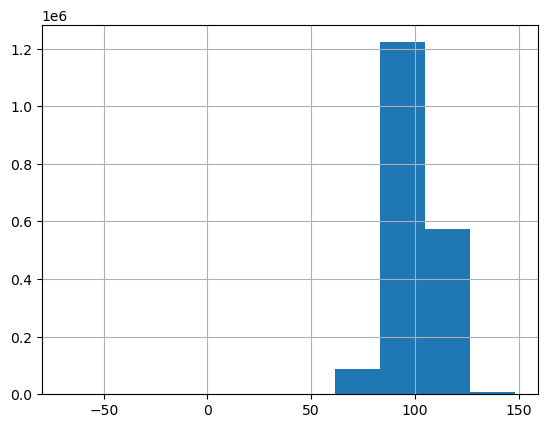

In [ ]:
X['stuff+'].hist()

In [ ]:
100 + (10 * (0.003394 - y_pred.mean() / y_pred.std()))

np.float64(99.1840263773893)

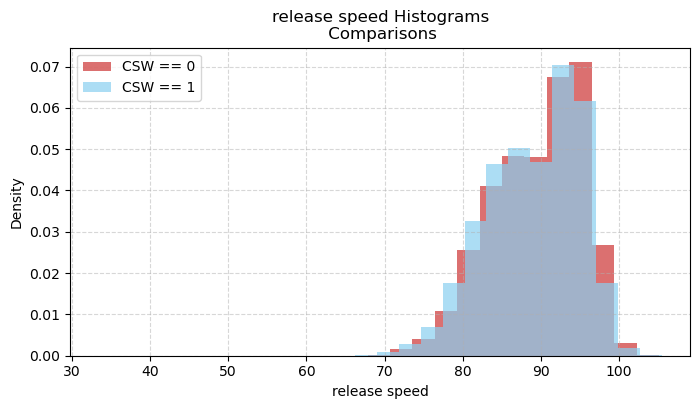

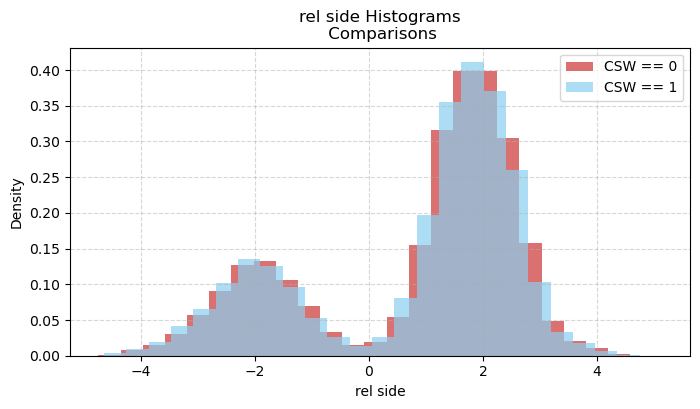

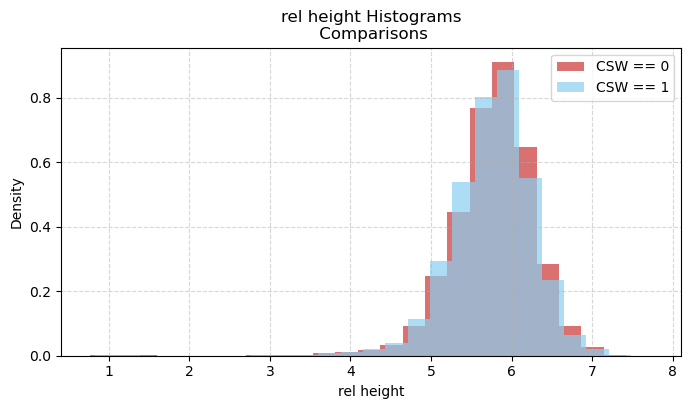

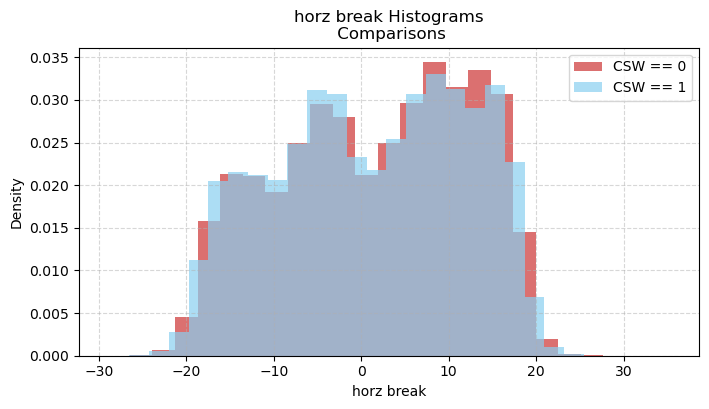

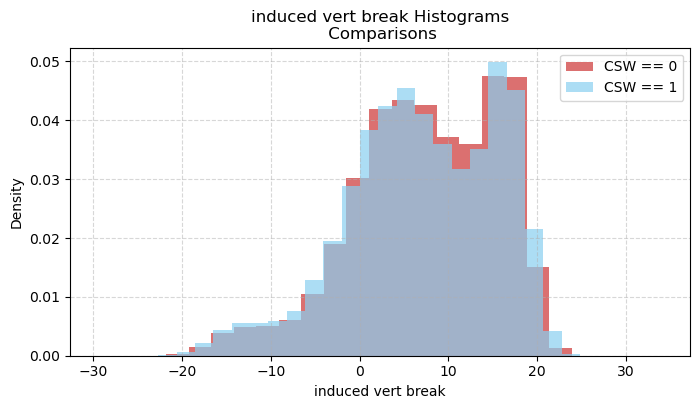

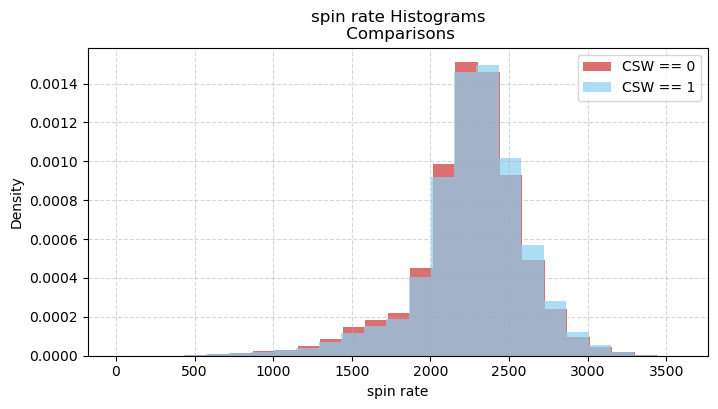

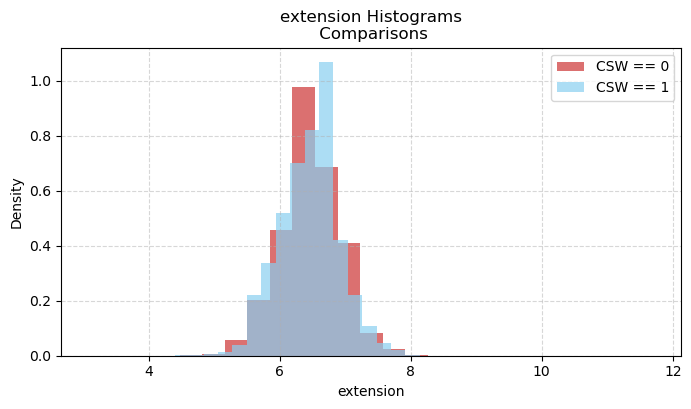

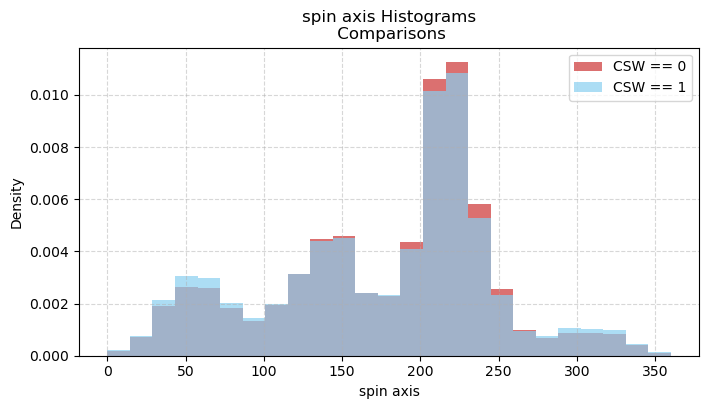

In [ ]:
for i in ['release_speed', 'rel_side', 'rel_height', 'horz_break', 'induced_vert_break', 'spin_rate', 'extension', 'spin_axis']:
    catch_made_hist(statcast_data_cleaned, i)

## Result Testing

In [17]:
deep_stats = pitching_stats(2024)
deep_stats.head()

,IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,GS,CG,ShO,SV,BS,IP,TBF,H,R,ER,HR,BB,IBB,HBP,WP,BK,SO,GB,FB,LD,IFFB,Balls,Strikes,Pitches,RS,IFH,BU,BUH,K/9,BB/9,K/BB,H/9,HR/9,AVG,WHIP,BABIP,LOB%,FIP,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,IFH%,BUH%,Starting,Start-IP,Relieving,Relief-IP,RAR,Dollars,tERA,xFIP,WPA,-WPA,+WPA,RE24,REW,pLI,inLI,gmLI,exLI,Pulls,WPA/LI,Clutch,FB% 2,FBv,SL%,SLv,CT%,CTv,CB%,CBv,CH%,CHv,SF%,SFv,KN%,KNv,XX%,PO%,wFB,wSL,wCT,wCB,wCH,wSF,wKN,wFB/C,wSL/C,wCT/C,wCB/C,wCH/C,wSF/C,wKN/C,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%,HLD,SD,MD,ERA-,FIP-,xFIP-,K%,BB%,SIERA,RS/9,E-F,FA% (sc),FT% (sc),FC% (sc),FS% (sc),FO% (sc),SI% (sc),SL% (sc),CU% (sc),KC% (sc),EP% (sc),CH% (sc),SC% (sc),KN% (sc),UN% (sc),vFA (sc),vFT (sc),vFC (sc),vFS (sc),vFO (sc),vSI (sc),vSL (sc),vCU (sc),vKC (sc),vEP (sc),vCH (sc),vSC (sc),vKN (sc),FA-X (sc),FT-X (sc),FC-X (sc),FS-X (sc),FO-X (sc),SI-X (sc),SL-X (sc),CU-X (sc),KC-X (sc),EP-X (sc),CH-X (sc),SC-X (sc),KN-X (sc),FA-Z (sc),FT-Z (sc),FC-Z (sc),FS-Z (sc),FO-Z (sc),SI-Z (sc),SL-Z (sc),CU-Z (sc),KC-Z (sc),EP-Z (sc),CH-Z (sc),SC-Z (sc),KN-Z (sc),wFA (sc),wFT (sc),wFC (sc),wFS (sc),wFO (sc),wSI (sc),wSL (sc),wCU (sc),wKC (sc),wEP (sc),wCH (sc),wSC (sc),wKN (sc),wFA/C (sc),wFT/C (sc),wFC/C (sc),wFS/C (sc),wFO/C (sc),wSI/C (sc),wSL/C (sc),wCU/C (sc),wKC/C (sc),wEP/C (sc),wCH/C (sc),wSC/C (sc),wKN/C (sc),O-Swing% (sc),Z-Swing% (sc),Swing% (sc),O-Contact% (sc),Z-Contact% (sc),Contact% (sc),Zone% (sc),Pace,RA9-WAR,BIP-Wins,LOB-Wins,FDP-Wins,Age Rng,K-BB%,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%,kwERA,TTO%,CH% (pi),CS% (pi),CU% (pi),FA% (pi),FC% (pi),FS% (pi),KN% (pi),SB% (pi),SI% (pi),SL% (pi),XX% (pi),vCH (pi),vCS (pi),vCU (pi),vFA (pi),vFC (pi),vFS (pi),vKN (pi),vSB (pi),vSI (pi),vSL (pi),vXX (pi),CH-X (pi),CS-X (pi),CU-X (pi),FA-X (pi),FC-X (pi),FS-X (pi),KN-X (pi),SB-X (pi),SI-X (pi),SL-X (pi),XX-X (pi),CH-Z (pi),CS-Z (pi),CU-Z (pi),FA-Z (pi),FC-Z (pi),FS-Z (pi),KN-Z (pi),SB-Z (pi),SI-Z (pi),SL-Z (pi),XX-Z (pi),wCH (pi),wCS (pi),wCU (pi),wFA (pi),wFC (pi),wFS (pi),wKN (pi),wSB (pi),wSI (pi),wSL (pi),wXX (pi),wCH/C (pi),wCS/C (pi),wCU/C (pi),wFA/C (pi),wFC/C (pi),wFS/C (pi),wKN/C (pi),wSB/C (pi),wSI/C (pi),wSL/C (pi),wXX/C (pi),O-Swing% (pi),Z-Swing% (pi),Swing% (pi),O-Contact% (pi),Z-Contact% (pi),Contact% (pi),Zone% (pi),Pace (pi),FRM,K/9+,BB/9+,K/BB+,H/9+,HR/9+,AVG+,WHIP+,BABIP+,LOB%+,K%+,BB%+,LD%+,GB%+,FB%+,HR/FB%+,Pull%+,Cent%+,Oppo%+,Soft%+,Med%+,Hard%+,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xERA,botERA,botOvr CH,botStf CH,botCmd CH,botOvr CU,botStf CU,botCmd CU,botOvr FA,botStf FA,botCmd FA,botOvr SI,botStf SI,botCmd SI,botOvr SL,botStf SL,botCmd SL,botOvr KC,botStf KC,botCmd KC,botOvr FC,botStf FC,botCmd FC,botOvr FS,botStf FS,botCmd FS,botOvr,botStf,botCmd,botxRV100,Stf+ CH,Loc+ CH,Pit+ CH,Stf+ CU,Loc+ CU,Pit+ CU,Stf+ FA,Loc+ FA,Pit+ FA,Stf+ SI,Loc+ SI,Pit+ SI,Stf+ SL,Loc+ SL,Pit+ SL,Stf+ KC,Loc+ KC,Pit+ KC,Stf+ FC,Loc+ FC,Pit+ FC,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO
0,10603,2024,Chris Sale,ATL,35,18,3,6.4,2.38,29,29,0,0,0,0,177.2,702,141,48,47,9,39,0,8,4,1,225,191,143,92,8,925,1893,2818,126,5,4,0,11.40,1.98,5.77,7.14,0.46,0.215,1.01,0.314,0.798,2.09,1.34,0.216,0.448,0.336,0.056,0.063,0.026,0.000,56.2,177.2,NaN,NaN,56.2,$51.3,2.45,2.64,4.04,-9.08,13.12,41.11,4.24,0.95,0.90,0.87,0.83,29,4.37,-0.11,0.455,94.8,0.403,78.7,NaN,NaN,NaN,NaN,0.142,86.9,NaN,NaN,NaN,NaN,0.001,NaN,-5.5,24.4,NaN,NaN,12.1,NaN,NaN,-0.43,2.15,NaN,NaN,3.02,NaN,NaN,0.369,0.646,0.490,0.576,0.812,0.711,0.435,0.694,0.141,0,0,0,57,53,66,0.321,0.056,2.80,6.38,0.30,0.378,NaN,NaN,NaN,NaN,0.072,0.403,NaN,NaN,NaN,0.147,NaN,NaN,NaN,94.8,NaN,NaN,NaN,NaN,94.2,78.6,NaN,NaN,NaN,87.1,NaN,NaN,9.5,NaN,NaN,NaN,NaN,11.1,-5.3,NaN,NaN,NaN,10.1,NaN,NaN,5.8,NaN,NaN,NaN,NaN,1.6,-2.9,NaN,NaN,NaN,0.2,NaN,NaN,-1.3,NaN,NaN,NaN,NaN,-4.0,24.6,NaN,NaN,NaN,12.3,NaN,NaN,-0.12,NaN,NaN,NaN,NaN,-1.99,2.16,NaN,NaN,NaN,2.97,NaN,NaN,0.345,0.623,0.490,0.536,0.802,0.712,0.520,19.6,7.

In [18]:
deep_stats = deep_stats[['Name', 'WAR', 'ERA', 'FIP', 'xFIP', 'K%', 'BB%', 'O-Swing%', 'Z-Swing%', 'O-Contact%', 'Z-Contact%', 'EV', 'HardHit%', 'CSW%', 'Stuff+']].copy()
deep_stats['last_name'] = deep_stats['Name'].str.split().str[1]
deep_stats.head()

,Name,WAR,ERA,FIP,xFIP,K%,BB%,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,EV,HardHit%,CSW%,Stuff+,last_name
0,Chris Sale,6.4,2.38,2.09,2.64,0.321,0.056,0.369,0.646,0.576,0.812,86.5,0.307,0.323,104,Sale
1,Tarik Skubal,5.9,2.39,2.49,2.83,0.303,0.046,0.352,0.698,0.566,0.801,87.4,0.335,0.321,112,Skubal
2,Zack Wheeler,5.4,2.57,3.13,3.30,0.285,0.066,0.364,0.713,0.641,0.822,86.7,0.332,0.273,110,Wheeler
20,Dylan Cease,4.8,3.47,3.10,3.44,0.294,0.085,0.335,0.706,0.531,0.813,89.0,0.382,0.293,110,Cease
11,Cole Ragans,4.8,3.14,2.99,3.46,0.293,0.088,0.331,0.716,0.577,0.791,88.3,0.352,0.289,110,Ragans


In [19]:
pitch_count = statcast_data_cleaned.groupby('player_name').agg(
    total_pitches = ('pitch_name', 'count')
).reset_index()
pitch_type_count = statcast_data.groupby(['player_name', 'pitch_type']).agg(
    pitch_count = ('pitch_name', 'count')
).reset_index()

pitch_pct = pitch_type_count.merge(pitch_count, on = 'player_name', how = 'left')
pitch_pct['usage%'] = round(pitch_pct['pitch_count'] / pitch_pct['total_pitches'], 3) * 100
pitch_pct['last_name'] = pitch_pct['player_name'].str.split(',').str[0]
pitch_pct.head(8)

NameError: name 'statcast_data_cleaned' is not defined

In [20]:
deep_stats = pd.merge(deep_stats, pitch_pct, left_on = 'last_name', right_on = 'last_name', how = 'left').copy()
deep_stats = deep_stats.drop(columns = ['Name', 'last_name']).copy()
deep_stats[deep_stats['player_name'] == 'Sale, Chris']

NameError: name 'pitch_pct' is not defined

In [21]:
stuff_df = X[['pitcher', 'pitch_type', 'stuff+']].rename(columns={'pitcher': 'player_name'}).copy()
stuff_df[stuff_df['player_name'] == 'Crawford, Kutter']

NameError: name 'X' is not defined

In [22]:
both_stuffs = deep_stats.merge(stuff_df, on = ['player_name', 'pitch_type'], how = 'left')
both_stuffs = both_stuffs.rename(columns = {'stuff+': 'triStuff+'})
grouped_stuffs = both_stuffs.groupby(['player_name', 'pitch_type'])[['WAR', 'ERA', 'FIP', 'xFIP', 'O-Swing%', 'Z-Swing%', 'O-Contact%', 'Z-Contact%', 'Stuff+', 'triStuff+', 'usage%']].mean().reset_index()
grouped_stuffs.head()


NameError: name 'stuff_df' is not defined

In [23]:
grouped_stuffs['weighted_stuff'] = round((grouped_stuffs['usage%'] / 100) * grouped_stuffs['triStuff+'], 1)
wstuff = grouped_stuffs.groupby('player_name')[['weighted_stuff']].sum().reset_index()

#Clean final comparison dataset
compare_stuff = grouped_stuffs.merge(wstuff, on = ['player_name'], how = 'inner')
compare_stuff = compare_stuff.groupby('player_name')[['WAR', 'ERA', 'FIP', 'xFIP', 'O-Swing%', 'Z-Swing%', 'O-Contact%', 'Z-Contact%', 'Stuff+', 'weighted_stuff_y']].mean().reset_index().rename(columns = {'weighted_stuff_y': 'triStuff+'})
compare_stuff = compare_stuff[compare_stuff['triStuff+'] > 30]
compare_stuff

NameError: name 'grouped_stuffs' is not defined

In [24]:
plt.scatter(x = compare_stuff['Stuff+'], y = compare_stuff['triStuff+'])
plt.xlabel('MLB Stuff+')
plt.ylabel('triStuff+')
plt.title('Stuff+ Comparison')
plt.tight_layout()
plt.show()

NameError: name 'compare_stuff' is not defined

In [ ]:
from sklearn.metrics import r2_score

y_pred = compare_stuff.iloc[:, -1] 
y_true = compare_stuff.iloc[:, -2]

r2 = r2_score(y_pred, y_true)
print(f"R^2 Score: {r2:.3f}")

R^2 Score: -0.216


## Attempting Stuff+ based on Whiff%

In [16]:
master_trackman = pd.read_csv('../../Trackman CSV Files/merged_trackman_games.csv')
#only pitches where the batter swung the bat
master_trackman = master_trackman[
    (master_trackman['PitchCall'] == 'InPlay') | 
    (master_trackman['PitchCall'] == 'StrikeSwinging') | 
    (master_trackman['PitchCall'] == 'FoulBallNotFieldable') | 
    (master_trackman['PitchCall'] == 'FoulBallFieldable')].copy()
master_trackman

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence
10,11,2025-04-08,19:08:29.74,3,2,"Gilbert, Bradley",831228.0,Right,WAS_HUS,"Kane, Sam",1.000130e+09,Right,SEA_RED,Undefined,1,Top,0,1,0,Slider,Slider,InPlay,Undefined,FlyBall,Out,1,0,82.47056,-0.383361,-0.440782,2725.977171,103.286164,9:30,5.54619,0.73310,5.05082,-40.93014,2.95394,-4.66988,1.77377,-0.07179,73.21380,-7.896269,-1.267262,0.476788,90.93652,40.323030,-5.968970,4645.144480,109.49026,87.74028,-10.57539,276.41299,275.67360,-4.938970,5.767655,2.14748,2.11410,-0.68719,50.0,5.47771,1.12236,-119.19335,-2.29332,2.97746,30.63344,-29.24284,WAS_HUS,SEA_RED,UofWashington,D1,BIG10,20250408-UofWashington-1,ac9ce650-14e7-11f0-938f-b5417cf72451,79.05499,112.98566,NaN,9.25676,NaN,NaN,NaN,1.92576,1.81407,0.06270,6547872e-3314-45b6-a0d2-1680b11cc799,2025-04-09,02:08:29.74,2025-04-08T19:08:29.7445376-07:00,2025-04-09T02:08:29.7445376Z,FlyBall,v3,471486.0,4504,08 April 2025 21:05-seattleu@washington,"Blanchard, Colin",1.000114e+09,Right,WAS_HUS,a78ca147-3276-4e40-aa6f-de2e57250429,55.44242,-120.58398,15.31672,5.55169,-0.96583,-14.62142,-0.73508,0.98720,1.48873,181.546428,1.93125,101.03865,-23.29279,5.34465,-0.97811,0.14099,-0.01659,0.00148,-0.00007,1.81429,86.29089,-19.62613,1.43719,-0.08190,-0.05477,0.01928,-0.00255,0.00012,0.06210,-10.56361,2.87906,-0.68858,0.13260,-0.02020,0.00239,-0.00020,0.00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,High,Medium,NaN,NaN,NaN
11,12,2025-04-08,19:09:14.70,4,1,"Gilbert, Bradley",831228.0,Right,WAS_HUS,"Harmon, Reese",1.000062e+09,Left,SEA_RED,Undefined,1,Top,1,0,0,Fastball,Changeup,StrikeSwinging,Undefined,Undefined,Undefined,0,0,86.30064,0.511971,-1.939539,1846.654497,245.671297,2:15,5.53126,0.87571,5.47629,-29.85569,8.47300,15.91162,3.52263,0.38611,78.39705,-5.016898,0.8936

In [17]:
#encode whiffs
master_trackman['whiff'] = (master_trackman['PitchCall'] == 'StrikeSwinging') * 1
master_trackman[master_trackman['whiff'] == 1]

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,whiff
11,12,2025-04-08,19:09:14.70,4,1,"Gilbert, Bradley",8.312280e+05,Right,WAS_HUS,"Harmon, Reese",1.000062e+09,Left,SEA_RED,Undefined,1,Top,1,0,0,Fastball,Changeup,StrikeSwinging,Undefined,Undefined,Undefined,0,0,86.30064,0.511971,-1.939539,1846.654497,245.671297,2:15,5.53126,0.87571,5.47629,-29.85569,8.47300,15.91162,3.52263,0.38611,78.39705,-5.016898,0.893655,0.445588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.53410,4.51055,-0.71630,50.0,5.55619,3.53820,-125.16676,0.06812,-13.45867,26.65758,-25.06070,WAS_HUS,SEA_RED,UofWashington,D1,BIG10,20250408-UofWashington-1,c74cdeb0-14e7-11f0-938f-b5417cf72451,84.59036,NaN,NaN,7.90359,NaN,NaN,NaN,NaN,NaN,NaN,6547872e-3314-45b6-a0d2-1680b11cc799,2025-04-09,02:09:14.70,2025-04-08T19:09:14.7036672-07:00,2025-04-09T02:09:14.7036672Z,NaN,v3,471486.0,4504,08 April 2025 21:05-seattleu@washington,"Blanchard, Colin",1.000114e+09,Right,WAS_HUS,ac005141-3e42-413d-8ea4-a3be17c8f295,55.02034,-126.23145,13.32879,5.53348,1.06903,-12.53035,-0.86835,4.07573,-6.72934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,1
21,22,2025-04-08,19:14:49.01,5,4,"Gilbert, Bradley",8.312280e+05,Right,WAS_HUS,"Wagoner, Jake",1.010857e+07,Right,SEA_RED,Undefined,1,Top,1,2,1,Slider,Slider,StrikeSwinging,Undefined,Undefined,Undefined,0,0,80.34363,-0.712367,-0.883231,2730.111406,165.354574,11:30,5.59079,0.52358,5.09373,-33.82348,11.57520,-2.58209,2.10072,-0.52402,72.40271,-6.950331,-1.340142,0.484946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.98535,6.47815,-0.43804,50.0,5.49769,1.90322,-116.30379,-2.59828,1.32531,25.47726,-23.46068,WAS_HUS,SEA_RED,UofWashington,D1,BI

In [18]:
feature_cols = ['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle']
extra_cols = ['speed_diff', 'az0_diff', 'ax0_diff'] #Uses az0 and ax0 instead of IVB & HB (check tjStuff+)
target_cols = ['whiff']
valid_pitches = ['FourSeamFastBall', 'TwoSeamFastBall', 'Cutter', 'Sinker', 'Curveball', 'Slider', 'ChangeUp', 'Four-Seam', 'Fastball', 'Sweeper', 'Splitter']

## Data Cleaning

In [19]:
#Eliminate trash or NaN pitches
master_trackman = master_trackman[~(
    (master_trackman['TaggedPitchType'].isna()) | 
    (master_trackman['TaggedPitchType'] == 'Other') | 
    (master_trackman['TaggedPitchType'] == 'Knuckleball') | 
    (master_trackman['TaggedPitchType'] == 'Undefined'))]

#imputes missing pitch metrics (fills with the mean of that pitcher's other)
master_trackman['Extension'] = master_trackman['Extension'].fillna(master_trackman.groupby(['Pitcher'])['Extension'].transform('mean'))
master_trackman['SpinRate'] = master_trackman['SpinRate'].fillna(master_trackman.groupby(['Pitcher', 'AutoPitchType'])['SpinRate'].transform('mean'))
master_trackman['InducedVertBreak'] = master_trackman['InducedVertBreak'].fillna(master_trackman.groupby(['Pitcher', 'AutoPitchType'])['InducedVertBreak'].transform('mean'))
master_trackman['HorzBreak'] = master_trackman['HorzBreak'].fillna(master_trackman.groupby(['Pitcher', 'AutoPitchType'])['HorzBreak'].transform('mean'))
master_trackman['RelSpeed'] = master_trackman['RelSpeed'].fillna(master_trackman.groupby(['Pitcher', 'AutoPitchType'])['RelSpeed'].transform('mean'))
master_trackman['VertApprAngle'] = master_trackman['VertApprAngle'].fillna(master_trackman.groupby(['Pitcher'])['VertApprAngle'].transform('mean'))
master_trackman['HorzApprAngle'] = master_trackman['HorzApprAngle'].fillna(master_trackman.groupby(['Pitcher'])['HorzApprAngle'].transform('mean'))
master_trackman['RelHeight'] = master_trackman['RelHeight'].fillna(master_trackman.groupby(['Pitcher'])['RelHeight'].transform('mean'))
master_trackman['RelSide'] = master_trackman['RelSide'].fillna(master_trackman.groupby(['Pitcher'])['RelSide'].transform('mean'))

#Eliminate outlier pitchers, potential trackman misreads
means = master_trackman.groupby('AutoPitchType')[feature_cols].transform('mean')
stds  = master_trackman.groupby('AutoPitchType')[feature_cols].transform('std')
mask = ((master_trackman[feature_cols] - means).abs() <= 3 * stds).all(axis=1)
master_trackman = master_trackman[mask]

swinging_cleaned = master_trackman.dropna(subset=feature_cols)
swinging_cleaned

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,whiff
10,11,2025-04-08,19:08:29.74,3,2,"Gilbert, Bradley",831228.0,Right,WAS_HUS,"Kane, Sam",1.000130e+09,Right,SEA_RED,Undefined,1,Top,0,1,0,Slider,Slider,InPlay,Undefined,FlyBall,Out,1,0,82.47056,-0.383361,-0.440782,2725.977171,103.286164,9:30,5.54619,0.73310,5.05082,-40.93014,2.95394,-4.66988,1.77377,-0.07179,73.21380,-7.896269,-1.267262,0.476788,90.93652,40.323030,-5.968970,4645.144480,109.49026,87.74028,-10.57539,276.41299,275.67360,-4.938970,5.767655,2.14748,2.11410,-0.68719,50.0,5.47771,1.12236,-119.19335,-2.29332,2.97746,30.63344,-29.24284,WAS_HUS,SEA_RED,UofWashington,D1,BIG10,20250408-UofWashington-1,ac9ce650-14e7-11f0-938f-b5417cf72451,79.05499,112.98566,NaN,9.25676,NaN,NaN,NaN,1.92576,1.81407,0.06270,6547872e-3314-45b6-a0d2-1680b11cc799,2025-04-09,02:08:29.74,2025-04-08T19:08:29.7445376-07:00,2025-04-09T02:08:29.7445376Z,FlyBall,v3,471486.0,4504,08 April 2025 21:05-seattleu@washington,"Blanchard, Colin",1.000114e+09,Right,WAS_HUS,a78ca147-3276-4e40-aa6f-de2e57250429,55.44242,-120.58398,15.31672,5.55169,-0.96583,-14.62142,-0.73508,0.98720,1.48873,181.546428,1.93125,101.03865,-23.29279,5.34465,-0.97811,0.14099,-0.01659,0.00148,-0.00007,1.81429,86.29089,-19.62613,1.43719,-0.08190,-0.05477,0.01928,-0.00255,0.00012,0.06210,-10.56361,2.87906,-0.68858,0.13260,-0.02020,0.00239,-0.00020,0.00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,High,Medium,NaN,NaN,NaN,0
11,12,2025-04-08,19:09:14.70,4,1,"Gilbert, Bradley",831228.0,Right,WAS_HUS,"Harmon, Reese",1.000062e+09,Left,SEA_RED,Undefined,1,Top,1,0,0,Fastball,Changeup,StrikeSwinging,Undefined,Undefined,Undefined,0,0,86.30064,0.511971,-1.939539,1846.654497,245.671297,2:15,5.53126,0.87571,5.47629,-29.85569,8.47300,15.91162,3.52263,0.38611,78.39705,-5.01689

In [22]:
#Mirror handedness

def mirror_handedness(row):
    
    # Encode 0 to LHP and 1 to RHP
    row['handedness_encode'] = int(row['PitcherThrows'] == 'Right')
    
    # Mirror if left
    if row['handedness_encode'] == 0: 
        row['HorzBreak'] *= -1
        row['ax0'] *= -1
        row['RelSide'] *= -1
        row['HorzApprAngle'] *= -1
    return row

encoded_trackman = swinging_cleaned.apply(mirror_handedness, axis = 1)
encoded_trackman

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,whiff,handedness_encode
10,11,2025-04-08,19:08:29.74,3,2,"Gilbert, Bradley",831228.0,Right,WAS_HUS,"Kane, Sam",1.000130e+09,Right,SEA_RED,Undefined,1,Top,0,1,0,Slider,Slider,InPlay,Undefined,FlyBall,Out,1,0,82.47056,-0.383361,-0.440782,2725.977171,103.286164,9:30,5.54619,0.73310,5.05082,-40.93014,2.95394,-4.66988,1.77377,-0.07179,73.21380,-7.896269,-1.267262,0.476788,90.93652,40.323030,-5.968970,4645.144480,109.49026,87.74028,-10.57539,276.41299,275.67360,-4.938970,5.767655,2.14748,2.11410,-0.68719,50.0,5.47771,1.12236,-119.19335,-2.29332,2.97746,30.63344,-29.24284,WAS_HUS,SEA_RED,UofWashington,D1,BIG10,20250408-UofWashington-1,ac9ce650-14e7-11f0-938f-b5417cf72451,79.05499,112.98566,NaN,9.25676,NaN,NaN,NaN,1.92576,1.81407,0.06270,6547872e-3314-45b6-a0d2-1680b11cc799,2025-04-09,02:08:29.74,2025-04-08T19:08:29.7445376-07:00,2025-04-09T02:08:29.7445376Z,FlyBall,v3,471486.0,4504,08 April 2025 21:05-seattleu@washington,"Blanchard, Colin",1.000114e+09,Right,WAS_HUS,a78ca147-3276-4e40-aa6f-de2e57250429,55.44242,-120.58398,15.31672,5.55169,-0.96583,-14.62142,-0.73508,0.98720,1.48873,181.546428,1.93125,101.03865,-23.29279,5.34465,-0.97811,0.14099,-0.01659,0.00148,-0.00007,1.81429,86.29089,-19.62613,1.43719,-0.08190,-0.05477,0.01928,-0.00255,0.00012,0.06210,-10.56361,2.87906,-0.68858,0.13260,-0.02020,0.00239,-0.00020,0.00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,High,Medium,NaN,NaN,NaN,0,1
11,12,2025-04-08,19:09:14.70,4,1,"Gilbert, Bradley",831228.0,Right,WAS_HUS,"Harmon, Reese",1.000062e+09,Left,SEA_RED,Undefined,1,Top,1,0,0,Fastball,Changeup,StrikeSwinging,Undefined,Undefined,Undefined,0,0,86.30064,0.511971,-1.939539,1846.654497,245.671297,2:15,5.53126,0.87571,5.47629,-29.85569,8.47300,15.91162,3.52263,0.386

In [23]:
## Finding metric differences against pitcher's avg fastball metrics

fb = encoded_trackman[(encoded_trackman['TaggedPitchType'] == 'FourSeamFastBall') | (encoded_trackman['TaggedPitchType'] == 'Fastball')]
avg_fb = fb.groupby('Pitcher').agg(
    avg_speed = ('RelSpeed', 'mean'),
    avg_vert_az = ('az0', 'mean'),
    avg_horz_ax = ('ax0', 'mean'),
    avg_ivb = ('InducedVertBreak', 'mean'),
    avb_hb = ('HorzBreak', 'mean'),
    pitch_count = ('PitchNo', 'count')
    ).reset_index()
avg_fb = avg_fb[avg_fb['pitch_count'] > 2]
avg_fb = avg_fb.drop(columns = ['pitch_count']).copy()

avg_fb.head()

encoded_avg = encoded_trackman.merge(avg_fb, on = ['Pitcher'], how = 'inner')
encoded_avg['speed_diff'] = encoded_avg['RelSpeed'] - encoded_avg['avg_speed']
encoded_avg['az0_diff'] = encoded_avg['az0'] - encoded_avg['avg_vert_az']
encoded_avg['ax0_diff'] = encoded_avg['ax0'] - encoded_avg['avg_horz_ax']
encoded_avg['IVB_diff'] = encoded_avg['InducedVertBreak'] - encoded_avg['avg_ivb']
encoded_avg['HB_diff'] = encoded_avg['HorzBreak'] - encoded_avg['avb_hb']

encoded_avg.head()

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,whiff,handedness_encode,avg_speed,avg_vert_az,avg_horz_ax,avg_ivb,avb_hb,speed_diff,az0_diff,ax0_diff,IVB_diff,HB_diff
0,11,2025-04-08,19:08:29.74,3,2,"Gilbert, Bradley",831228.0,Right,WAS_HUS,"Kane, Sam",1.000130e+09,Right,SEA_RED,Undefined,1,Top,0,1,0,Slider,Slider,InPlay,Undefined,FlyBall,Out,1,0,82.47056,-0.383361,-0.440782,2725.977171,103.286164,9:30,5.54619,0.73310,5.05082,-40.93014,2.95394,-4.66988,1.77377,-0.07179,73.21380,-7.896269,-1.267262,0.476788,90.93652,40.323030,-5.968970,4645.144480,109.49026,87.74028,-10.57539,276.41299,275.67360,-4.938970,5.767655,2.14748,2.11410,-0.68719,50.0,5.47771,1.12236,-119.19335,-2.29332,2.97746,30.63344,-29.24284,WAS_HUS,SEA_RED,UofWashington,D1,BIG10,20250408-UofWashington-1,ac9ce650-14e7-11f0-938f-b5417cf72451,79.05499,112.98566,NaN,9.25676,NaN,NaN,NaN,1.92576,1.81407,0.06270,6547872e-3314-45b6-a0d2-1680b11cc799,2025-04-09,02:08:29.74,2025-04-08T19:08:29.7445376-07:00,2025-04-09T02:08:29.7445376Z,FlyBall,v3,471486.0,4504,08 April 2025 21:05-seattleu@washington,"Blanchard, Colin",1.000114e+09,Right,WAS_HUS,a78ca147-3276-4e40-aa6f-de2e57250429,55.44242,-120.58398,15.31672,5.55169,-0.96583,-14.62142,-0.73508,0.98720,1.48873,181.546428,1.93125,101.03865,-23.29279,5.34465,-0.97811,0.14099,-0.01659,0.00148,-0.00007,1.81429,86.29089,-19.62613,1.43719,-0.08190,-0.05477,0.01928,-0.00255,0.00012,0.06210,-10.56361,2.87906,-0.68858,0.13260,-0.02020,0.00239,-0.00020,0.00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,High,Medium,NaN,NaN,NaN,0,1,88.662359,-14.496292,-6.755169,19.284547,7.186402,-6.191799,-14.746548,9.732629,-16.330607,-11.856282
1,12,2025-04-08,19:09:14.70,4,1,"Gilbert, Bradley",831228.0,Right,WAS_HUS,"Harmon, Reese",1.000062e+09,Left,SEA_RED,Undefined,1,To

In [68]:
feature_cols = ['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle', 'speed_diff', 'IVB_diff', 'HB_diff']

In [69]:
X = encoded_avg[feature_cols + target_cols]

#Cleaning more
X = X.replace({pd.NA: np.nan})
X = X.astype({col: float for col in ["RelSpeed", "SpinRate", 
                                     "InducedVertBreak", "HorzBreak", 
                                     "Extension", 
                                     "RelSide", "RelHeight", "VertApprAngle"]})
X = X.dropna(subset=["RelSpeed", "SpinRate", "InducedVertBreak", "HorzBreak", 
                    "Extension", "RelSide", "RelHeight", "VertApprAngle"])

X.head()

,RelSpeed,SpinRate,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,speed_diff,IVB_diff,HB_diff,whiff
0,82.47056,2725.977171,5.54619,0.73310,5.05082,2.95394,-4.66988,-7.896269,-1.267262,-6.191799,-16.330607,-11.856282,0
1,86.30064,1846.654497,5.53126,0.87571,5.47629,8.47300,15.91162,-5.016898,0.893655,-2.361719,-10.811547,8.725218,1
2,89.25206,2500.494129,5.71908,0.54005,5.99446,25.43025,9.50875,-3.581706,-0.115125,0.589701,6.145703,2.322348,0
3,89.31221,2529.515979,5.65845,0.80330,5.77700,18.85470,3.91642,-3.519443,-0.459806,0.649851,-0.429847,-3.269982,0
4,88.66217,2431.139672,5.67713,0.63413,6.01230,22.25084,5.05914,-4.415048,-0.969016,-0.000189,2.966293,-2.127262,0


In [70]:
#Standardize features
y = X['whiff'].values
X = X[feature_cols].values
## potentially use robustscaler(), could be better to penalize outliers

### XGBoost Model

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:33:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:33:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:33:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8820207917706628, gamma=3.6386287158866253, learning_rate=0.2387586688716479, max_depth=5, min_child_weight=7, n_estimators=473, reg_alpha=6.41875322570087e-06, reg_lambda=0.008242023975484281, subsample=0.6522316555182531; total time=   3.5s
[CV] END colsample_bytree=0.8820207917706628, gamma=3.6386287158866253, learning_rate=0.2387586688716479, max_depth=5, min_child_weight=7, n_estimators=473, reg_alpha=6.41875322570087e-06, reg_lambda=0.008242023975484281, subsample=0.6522316555182531; total time=   3.6s
[CV] END colsample_bytree=0.8820207917706628, gamma=3.6386287158866253, learning_rate=0.2387586688716479, max_depth=5, min_child_weight=7, n_estimators=473, reg_alpha=6.41875322570087e-06, reg_lambda=0.008242023975484281, subsample=0.6522316555182531; total time=   3.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:33:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:33:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:33:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9674776711106569, gamma=4.416576386904311, learning_rate=0.02806554771929606, max_depth=12, min_child_weight=9, n_estimators=156, reg_alpha=1.2778159542148633e-07, reg_lambda=6.740609700244838e-06, subsample=0.8178645509395852; total time=   5.5s
[CV] END colsample_bytree=0.9674776711106569, gamma=4.416576386904311, learning_rate=0.02806554771929606, max_depth=12, min_child_weight=9, n_estimators=156, reg_alpha=1.2778159542148633e-07, reg_lambda=6.740609700244838e-06, subsample=0.8178645509395852; total time=   5.5s
[CV] END colsample_bytree=0.9674776711106569, gamma=4.416576386904311, learning_rate=0.02806554771929606, max_depth=12, min_child_weight=9, n_estimators=156, reg_alpha=1.2778159542148633e-07, reg_lambda=6.740609700244838e-06, subsample=0.8178645509395852; total time=   5.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8889665024602303, gamma=4.593612608346885, learning_rate=0.014285310742471472, max_depth=6, min_child_weight=3, n_estimators=508, reg_alpha=1.752203051791065e-07, reg_lambda=0.010290115529733822, subsample=0.7786702115169006; total time=   5.8s
[CV] END colsample_bytree=0.8889665024602303, gamma=4.593612608346885, learning_rate=0.014285310742471472, max_depth=6, min_child_weight=3, n_estimators=508, reg_alpha=1.752203051791065e-07, reg_lambda=0.010290115529733822, subsample=0.7786702115169006; total time=   5.9s
[CV] END colsample_bytree=0.8889665024602303, gamma=4.593612608346885, learning_rate=0.014285310742471472, max_depth=6, min_child_weight=3, n_estimators=508, reg_alpha=1.752203051791065e-07, reg_lambda=0.010290115529733822, subsample=0.7786702115169006; total time=   5.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:33:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:33:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:33:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9624791976714727, gamma=0.8593578069828035, learning_rate=0.07645185888630145, max_depth=10, min_child_weight=6, n_estimators=186, reg_alpha=0.01112767063707828, reg_lambda=0.09572884664006703, subsample=0.9559644307534418; total time=   4.1s
[CV] END colsample_bytree=0.9624791976714727, gamma=0.8593578069828035, learning_rate=0.07645185888630145, max_depth=10, min_child_weight=6, n_estimators=186, reg_alpha=0.01112767063707828, reg_lambda=0.09572884664006703, subsample=0.9559644307534418; total time=   4.2s
[CV] END colsample_bytree=0.9624791976714727, gamma=0.8593578069828035, learning_rate=0.07645185888630145, max_depth=10, min_child_weight=6, n_estimators=186, reg_alpha=0.01112767063707828, reg_lambda=0.09572884664006703, subsample=0.9559644307534418; total time=   4.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:33:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:33:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:33:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9599106883214347, gamma=2.190145932204617, learning_rate=0.05996280567850356, max_depth=9, min_child_weight=9, n_estimators=745, reg_alpha=2.474141760379292e-05, reg_lambda=0.0015932092308169063, subsample=0.6765419227639857; total time=  10.3s
[CV] END colsample_bytree=0.9599106883214347, gamma=2.190145932204617, learning_rate=0.05996280567850356, max_depth=9, min_child_weight=9, n_estimators=745, reg_alpha=2.474141760379292e-05, reg_lambda=0.0015932092308169063, subsample=0.6765419227639857; total time=  10.5s
[CV] END colsample_bytree=0.9599106883214347, gamma=2.190145932204617, learning_rate=0.05996280567850356, max_depth=9, min_child_weight=9, n_estimators=745, reg_alpha=2.474141760379292e-05, reg_lambda=0.0015932092308169063, subsample=0.6765419227639857; total time=  10.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:33:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9468056035971137, gamma=4.6968486880138585, learning_rate=0.017444866126918635, max_depth=4, min_child_weight=8, n_estimators=435, reg_alpha=4.701063453565855e-05, reg_lambda=0.00018972356688004796, subsample=0.8926419685712479; total time=   3.3s
[CV] END colsample_bytree=0.9468056035971137, gamma=4.6968486880138585, learning_rate=0.017444866126918635, max_depth=4, min_child_weight=8, n_estimators=435, reg_alpha=4.701063453565855e-05, reg_lambda=0.00018972356688004796, subsample=0.8926419685712479; total time=   3.4s
[CV] END colsample_bytree=0.9468056035971137, gamma=4.6968486880138585, learning_rate=0.017444866126918635, max_depth=4, min_child_weight=8, n_estimators=435, reg_alpha=4.701063453565855e-05, reg_lambda=0.00018972356688004796, subsample=0.8926419685712479; total time=   3.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9234158717004632, gamma=3.876821894139413, learning_rate=0.03390942329293072, max_depth=11, min_child_weight=6, n_estimators=635, reg_alpha=0.0015496016767113624, reg_lambda=2.380458900415406e-05, subsample=0.866941242634403; total time=   7.0s
[CV] END colsample_bytree=0.9234158717004632, gamma=3.876821894139413, learning_rate=0.03390942329293072, max_depth=11, min_child_weight=6, n_estimators=635, reg_alpha=0.0015496016767113624, reg_lambda=2.380458900415406e-05, subsample=0.866941242634403; total time=   7.0s
[CV] END colsample_bytree=0.9234158717004632, gamma=3.876821894139413, learning_rate=0.03390942329293072, max_depth=11, min_child_weight=6, n_estimators=635, reg_alpha=0.0015496016767113624, reg_lambda=2.380458900415406e-05, subsample=0.866941242634403; total time=   7.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9086806135380625, gamma=4.600046132186582, learning_rate=0.05411797281355388, max_depth=10, min_child_weight=4, n_estimators=146, reg_alpha=0.0003683175570745102, reg_lambda=1.608454130933308e-08, subsample=0.6928647954923324; total time=   3.2s
[CV] END colsample_bytree=0.9086806135380625, gamma=4.600046132186582, learning_rate=0.05411797281355388, max_depth=10, min_child_weight=4, n_estimators=146, reg_alpha=0.0003683175570745102, reg_lambda=1.608454130933308e-08, subsample=0.6928647954923324; total time=   3.3s
[CV] END colsample_bytree=0.9086806135380625, gamma=4.600046132186582, learning_rate=0.05411797281355388, max_depth=10, min_child_weight=4, n_estimators=146, reg_alpha=0.0003683175570745102, reg_lambda=1.608454130933308e-08, subsample=0.6928647954923324; total time=   3.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9910955972619857, gamma=3.50310722310683, learning_rate=0.1938811514231446, max_depth=6, min_child_weight=4, n_estimators=290, reg_alpha=1.0011252290198509e-08, reg_lambda=9.235999512067954e-06, subsample=0.7971894567956928; total time=   2.2s
[CV] END colsample_bytree=0.9910955972619857, gamma=3.50310722310683, learning_rate=0.1938811514231446, max_depth=6, min_child_weight=4, n_estimators=290, reg_alpha=1.0011252290198509e-08, reg_lambda=9.235999512067954e-06, subsample=0.7971894567956928; total time=   2.3s
[CV] END colsample_bytree=0.9910955972619857, gamma=3.50310722310683, learning_rate=0.1938811514231446, max_depth=6, min_child_weight=4, n_estimators=290, reg_alpha=1.0011252290198509e-08, reg_lambda=9.235999512067954e-06, subsample=0.7971894567956928; total time=   2.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8007260614509487, gamma=4.089150098318758, learning_rate=0.12444128798312445, max_depth=5, min_child_weight=6, n_estimators=347, reg_alpha=3.1821045889801837e-06, reg_lambda=1.6624810157954234e-07, subsample=0.9469190305262598; total time=   2.2s
[CV] END colsample_bytree=0.8007260614509487, gamma=4.089150098318758, learning_rate=0.12444128798312445, max_depth=5, min_child_weight=6, n_estimators=347, reg_alpha=3.1821045889801837e-06, reg_lambda=1.6624810157954234e-07, subsample=0.9469190305262598; total time=   2.2s
[CV] END colsample_bytree=0.8007260614509487, gamma=4.089150098318758, learning_rate=0.12444128798312445, max_depth=5, min_child_weight=6, n_estimators=347, reg_alpha=3.1821045889801837e-06, reg_lambda=1.6624810157954234e-07, subsample=0.9469190305262598; total time=   2.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8970918838836922, gamma=2.6291923997730966, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=9, n_estimators=1000, reg_alpha=3.198309099955623e-07, reg_lambda=1.0, subsample=0.5; total time=  13.1s
[CV] END colsample_bytree=0.8970918838836922, gamma=2.6291923997730966, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=9, n_estimators=1000, reg_alpha=3.198309099955623e-07, reg_lambda=1.0, subsample=0.5; total time=  13.2s
[CV] END colsample_bytree=0.8970918838836922, gamma=2.6291923997730966, learning_rate=0.29999999999999993, max_depth=12, min_child_weight=9, n_estimators=1000, reg_alpha=3.198309099955623e-07, reg_lambda=1.0, subsample=0.5; total time=  13.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=5.0, learning_rate=0.29999999999999993, max_depth=8, min_child_weight=1, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0, subsample=0.5; total time=   6.8s
[CV] END colsample_bytree=0.8, gamma=5.0, learning_rate=0.29999999999999993, max_depth=8, min_child_weight=1, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0, subsample=0.5; total time=   6.9s
[CV] END colsample_bytree=0.8, gamma=5.0, learning_rate=0.29999999999999993, max_depth=8, min_child_weight=1, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0, subsample=0.5; total time=   7.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8179118156297445, gamma=1.916280797593013, learning_rate=0.29999999999999993, max_depth=8, min_child_weight=10, n_estimators=1000, reg_alpha=9.45286323685926e-05, reg_lambda=1.0, subsample=0.935682370407521; total time=   4.6s
[CV] END colsample_bytree=0.8179118156297445, gamma=1.916280797593013, learning_rate=0.29999999999999993, max_depth=8, min_child_weight=10, n_estimators=1000, reg_alpha=9.45286323685926e-05, reg_lambda=1.0, subsample=0.935682370407521; total time=   4.6s
[CV] END colsample_bytree=0.8179118156297445, gamma=1.916280797593013, learning_rate=0.29999999999999993, max_depth=8, min_child_weight=10, n_estimators=1000, reg_alpha=9.45286323685926e-05, reg_lambda=1.0, subsample=0.935682370407521; total time=   4.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:34:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8110556690896474, gamma=3.654826266608038, learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=1000, reg_alpha=3.125842437236595e-08, reg_lambda=1.0, subsample=0.5; total time=  21.2s
[CV] END colsample_bytree=0.8110556690896474, gamma=3.654826266608038, learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=1000, reg_alpha=3.125842437236595e-08, reg_lambda=1.0, subsample=0.5; total time=  21.3s
[CV] END colsample_bytree=0.8110556690896474, gamma=3.654826266608038, learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=1000, reg_alpha=3.125842437236595e-08, reg_lambda=1.0, subsample=0.5; total time=  21.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:35:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:35:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:35:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8865961515789529, gamma=3.2913333721730753, learning_rate=0.29999999999999993, max_depth=2, min_child_weight=5, n_estimators=369, reg_alpha=7.174996368811545e-07, reg_lambda=0.2935583952316308, subsample=0.5335101997035775; total time=   2.5s
[CV] END colsample_bytree=0.8865961515789529, gamma=3.2913333721730753, learning_rate=0.29999999999999993, max_depth=2, min_child_weight=5, n_estimators=369, reg_alpha=7.174996368811545e-07, reg_lambda=0.2935583952316308, subsample=0.5335101997035775; total time=   2.5s
[CV] END colsample_bytree=0.8865961515789529, gamma=3.2913333721730753, learning_rate=0.29999999999999993, max_depth=2, min_child_weight=5, n_estimators=369, reg_alpha=7.174996368811545e-07, reg_lambda=0.2935583952316308, subsample=0.5335101997035775; total time=   2.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:35:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:35:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:35:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9130572987803214, gamma=1.3835122349180697, learning_rate=0.28696512301462523, max_depth=12, min_child_weight=1, n_estimators=500, reg_alpha=6.374733004195616e-06, reg_lambda=1.7273110067376005e-08, subsample=0.7487302884426399; total time=   6.5s
[CV] END colsample_bytree=0.9130572987803214, gamma=1.3835122349180697, learning_rate=0.28696512301462523, max_depth=12, min_child_weight=1, n_estimators=500, reg_alpha=6.374733004195616e-06, reg_lambda=1.7273110067376005e-08, subsample=0.7487302884426399; total time=   6.5s
[CV] END colsample_bytree=0.9130572987803214, gamma=1.3835122349180697, learning_rate=0.28696512301462523, max_depth=12, min_child_weight=1, n_estimators=500, reg_alpha=6.374733004195616e-06, reg_lambda=1.7273110067376005e-08, subsample=0.7487302884426399; total time=   6.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:35:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:35:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:35:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.29999999999999993, max_depth=7, min_child_weight=2, n_estimators=1000, reg_alpha=1.0, reg_lambda=1e-08, subsample=0.5; total time=  14.0s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.29999999999999993, max_depth=7, min_child_weight=2, n_estimators=1000, reg_alpha=1.0, reg_lambda=1e-08, subsample=0.5; total time=  14.0s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.29999999999999993, max_depth=7, min_child_weight=2, n_estimators=1000, reg_alpha=1.0, reg_lambda=1e-08, subsample=0.5; total time=  14.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:35:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:35:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:35:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9033640599156265, gamma=0.1733821690275317, learning_rate=0.07494754667008185, max_depth=12, min_child_weight=2, n_estimators=730, reg_alpha=0.0001089649216666703, reg_lambda=0.11920396546635156, subsample=0.5299546367342486; total time=  25.7s
[CV] END colsample_bytree=0.9033640599156265, gamma=0.1733821690275317, learning_rate=0.07494754667008185, max_depth=12, min_child_weight=2, n_estimators=730, reg_alpha=0.0001089649216666703, reg_lambda=0.11920396546635156, subsample=0.5299546367342486; total time=  25.8s
[CV] END colsample_bytree=0.9033640599156265, gamma=0.1733821690275317, learning_rate=0.07494754667008185, max_depth=12, min_child_weight=2, n_estimators=730, reg_alpha=0.0001089649216666703, reg_lambda=0.11920396546635156, subsample=0.5299546367342486; total time=  25.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:36:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:36:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:36:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.11873746530183192, max_depth=10, min_child_weight=8, n_estimators=1000, reg_alpha=1e-08, reg_lambda=1.0, subsample=0.5; total time=  21.8s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.11873746530183192, max_depth=10, min_child_weight=8, n_estimators=1000, reg_alpha=1e-08, reg_lambda=1.0, subsample=0.5; total time=  21.9s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.11873746530183192, max_depth=10, min_child_weight=8, n_estimators=1000, reg_alpha=1e-08, reg_lambda=1.0, subsample=0.5; total time=  21.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:36:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:36:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:36:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9234930401564801, gamma=0.3019636915362967, learning_rate=0.05943264712034387, max_depth=7, min_child_weight=3, n_estimators=936, reg_alpha=4.1705835680203166e-05, reg_lambda=0.4141725537096549, subsample=0.5431798273562133; total time=  12.5s
[CV] END colsample_bytree=0.9234930401564801, gamma=0.3019636915362967, learning_rate=0.05943264712034387, max_depth=7, min_child_weight=3, n_estimators=936, reg_alpha=4.1705835680203166e-05, reg_lambda=0.4141725537096549, subsample=0.5431798273562133; total time=  12.5s
[CV] END colsample_bytree=0.9234930401564801, gamma=0.3019636915362967, learning_rate=0.05943264712034387, max_depth=7, min_child_weight=3, n_estimators=936, reg_alpha=4.1705835680203166e-05, reg_lambda=0.4141725537096549, subsample=0.5431798273562133; total time=  12.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:36:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:36:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:36:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9290928642693514, gamma=0.5243806052741269, learning_rate=0.010093168254733324, max_depth=12, min_child_weight=5, n_estimators=917, reg_alpha=5.253101594846886e-06, reg_lambda=3.484417059706341e-08, subsample=0.990633611708247; total time=  33.1s
[CV] END colsample_bytree=0.9290928642693514, gamma=0.5243806052741269, learning_rate=0.010093168254733324, max_depth=12, min_child_weight=5, n_estimators=917, reg_alpha=5.253101594846886e-06, reg_lambda=3.484417059706341e-08, subsample=0.990633611708247; total time=  33.4s
[CV] END colsample_bytree=0.9290928642693514, gamma=0.5243806052741269, learning_rate=0.010093168254733324, max_depth=12, min_child_weight=5, n_estimators=917, reg_alpha=5.253101594846886e-06, reg_lambda=3.484417059706341e-08, subsample=0.990633611708247; total time=  33.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:37:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:37:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:37:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8367392450792178, gamma=0.07131906189891736, learning_rate=0.2198969935841165, max_depth=12, min_child_weight=2, n_estimators=986, reg_alpha=1.3903442033850263e-08, reg_lambda=6.445222844921865e-06, subsample=0.9905848267292079; total time=  17.9s
[CV] END colsample_bytree=0.8367392450792178, gamma=0.07131906189891736, learning_rate=0.2198969935841165, max_depth=12, min_child_weight=2, n_estimators=986, reg_alpha=1.3903442033850263e-08, reg_lambda=6.445222844921865e-06, subsample=0.9905848267292079; total time=  18.1s
[CV] END colsample_bytree=0.8367392450792178, gamma=0.07131906189891736, learning_rate=0.2198969935841165, max_depth=12, min_child_weight=2, n_estimators=986, reg_alpha=1.3903442033850263e-08, reg_lambda=6.445222844921865e-06, subsample=0.9905848267292079; total time=  18.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:37:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:37:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:37:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8496817420619164, gamma=0.19309043692807007, learning_rate=0.012490373506573728, max_depth=8, min_child_weight=3, n_estimators=888, reg_alpha=2.9798762847435164e-07, reg_lambda=1.369021535310071e-08, subsample=0.5899195857769559; total time=  14.8s
[CV] END colsample_bytree=0.8496817420619164, gamma=0.19309043692807007, learning_rate=0.012490373506573728, max_depth=8, min_child_weight=3, n_estimators=888, reg_alpha=2.9798762847435164e-07, reg_lambda=1.369021535310071e-08, subsample=0.5899195857769559; total time=  14.9s
[CV] END colsample_bytree=0.8496817420619164, gamma=0.19309043692807007, learning_rate=0.012490373506573728, max_depth=8, min_child_weight=3, n_estimators=888, reg_alpha=2.9798762847435164e-07, reg_lambda=1.369021535310071e-08, subsample=0.5899195857769559; total time=  14.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:37:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:37:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:37:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9634408938322732, gamma=0.015284936490078675, learning_rate=0.294515331306733, max_depth=4, min_child_weight=6, n_estimators=185, reg_alpha=8.404464005978217e-06, reg_lambda=0.1348277159073608, subsample=0.5091187802895801; total time=   1.9s
[CV] END colsample_bytree=0.9634408938322732, gamma=0.015284936490078675, learning_rate=0.294515331306733, max_depth=4, min_child_weight=6, n_estimators=185, reg_alpha=8.404464005978217e-06, reg_lambda=0.1348277159073608, subsample=0.5091187802895801; total time=   1.9s
[CV] END colsample_bytree=0.9634408938322732, gamma=0.015284936490078675, learning_rate=0.294515331306733, max_depth=4, min_child_weight=6, n_estimators=185, reg_alpha=8.404464005978217e-06, reg_lambda=0.1348277159073608, subsample=0.5091187802895801; total time=   1.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:37:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:37:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:37:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8502418617312391, gamma=0.09939205469461422, learning_rate=0.01426934421511444, max_depth=11, min_child_weight=10, n_estimators=320, reg_alpha=2.1909929331843956e-06, reg_lambda=0.016383753939773524, subsample=0.5154031266187897; total time=   9.9s
[CV] END colsample_bytree=0.8502418617312391, gamma=0.09939205469461422, learning_rate=0.01426934421511444, max_depth=11, min_child_weight=10, n_estimators=320, reg_alpha=2.1909929331843956e-06, reg_lambda=0.016383753939773524, subsample=0.5154031266187897; total time=   9.9s
[CV] END colsample_bytree=0.8502418617312391, gamma=0.09939205469461422, learning_rate=0.01426934421511444, max_depth=11, min_child_weight=10, n_estimators=320, reg_alpha=2.1909929331843956e-06, reg_lambda=0.016383753939773524, subsample=0.5154031266187897; total time=   9.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:38:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:38:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:38:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9752317853426882, gamma=1.2800952244557875, learning_rate=0.29999999999999993, max_depth=5, min_child_weight=2, n_estimators=709, reg_alpha=0.0508099520066158, reg_lambda=1.2372516727546438e-07, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.9752317853426882, gamma=1.2800952244557875, learning_rate=0.29999999999999993, max_depth=5, min_child_weight=2, n_estimators=709, reg_alpha=0.0508099520066158, reg_lambda=1.2372516727546438e-07, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.9752317853426882, gamma=1.2800952244557875, learning_rate=0.29999999999999993, max_depth=5, min_child_weight=2, n_estimators=709, reg_alpha=0.0508099520066158, reg_lambda=1.2372516727546438e-07, subsample=1.0; total time=   2.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:38:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:38:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:38:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9504557887072471, gamma=0.9554302472575147, learning_rate=0.2933657634731272, max_depth=9, min_child_weight=4, n_estimators=141, reg_alpha=1.7770493044311878e-05, reg_lambda=3.88622843191314e-05, subsample=0.511177429512899; total time=   3.0s
[CV] END colsample_bytree=0.9504557887072471, gamma=0.9554302472575147, learning_rate=0.2933657634731272, max_depth=9, min_child_weight=4, n_estimators=141, reg_alpha=1.7770493044311878e-05, reg_lambda=3.88622843191314e-05, subsample=0.511177429512899; total time=   3.0s
[CV] END colsample_bytree=0.9504557887072471, gamma=0.9554302472575147, learning_rate=0.2933657634731272, max_depth=9, min_child_weight=4, n_estimators=141, reg_alpha=1.7770493044311878e-05, reg_lambda=3.88622843191314e-05, subsample=0.511177429512899; total time=   3.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:38:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:38:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:38:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9955338627552277, gamma=4.85995112339141, learning_rate=0.22691779893256442, max_depth=12, min_child_weight=2, n_estimators=202, reg_alpha=0.002708709098312639, reg_lambda=0.7645494083639353, subsample=0.8839680679222851; total time=   1.9s
[CV] END colsample_bytree=0.9955338627552277, gamma=4.85995112339141, learning_rate=0.22691779893256442, max_depth=12, min_child_weight=2, n_estimators=202, reg_alpha=0.002708709098312639, reg_lambda=0.7645494083639353, subsample=0.8839680679222851; total time=   1.9s
[CV] END colsample_bytree=0.9955338627552277, gamma=4.85995112339141, learning_rate=0.22691779893256442, max_depth=12, min_child_weight=2, n_estimators=202, reg_alpha=0.002708709098312639, reg_lambda=0.7645494083639353, subsample=0.8839680679222851; total time=   1.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:38:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:38:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:38:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9267178397093481, gamma=1.8723760124364461, learning_rate=0.09037754735597439, max_depth=2, min_child_weight=6, n_estimators=985, reg_alpha=0.0014808317180972112, reg_lambda=1.4542260461361708e-08, subsample=0.5371666323665515; total time=   5.9s
[CV] END colsample_bytree=0.9267178397093481, gamma=1.8723760124364461, learning_rate=0.09037754735597439, max_depth=2, min_child_weight=6, n_estimators=985, reg_alpha=0.0014808317180972112, reg_lambda=1.4542260461361708e-08, subsample=0.5371666323665515; total time=   5.9s
[CV] END colsample_bytree=0.9267178397093481, gamma=1.8723760124364461, learning_rate=0.09037754735597439, max_depth=2, min_child_weight=6, n_estimators=985, reg_alpha=0.0014808317180972112, reg_lambda=1.4542260461361708e-08, subsample=0.5371666323665515; total time=   5.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:38:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:38:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:38:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8556864071569815, gamma=0.0, learning_rate=0.10353370480012693, max_depth=12, min_child_weight=8, n_estimators=1000, reg_alpha=1.0, reg_lambda=1e-08, subsample=0.5; total time=  30.8s
[CV] END colsample_bytree=0.8556864071569815, gamma=0.0, learning_rate=0.10353370480012693, max_depth=12, min_child_weight=8, n_estimators=1000, reg_alpha=1.0, reg_lambda=1e-08, subsample=0.5; total time=  30.9s
[CV] END colsample_bytree=0.8556864071569815, gamma=0.0, learning_rate=0.10353370480012693, max_depth=12, min_child_weight=8, n_estimators=1000, reg_alpha=1.0, reg_lambda=1e-08, subsample=0.5; total time=  30.9s
Test AUC: 0.7386442056566461
Brier Score: 0.14856604537269477
Test Log Loss: 0.4663943304462165


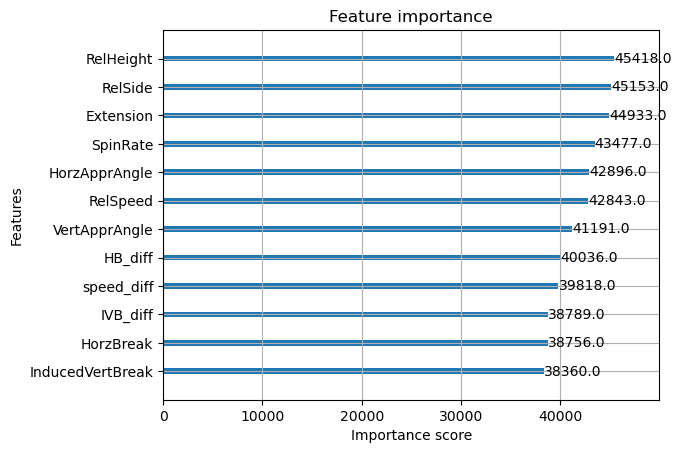

In [102]:
from skopt.space import Real, Integer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, make_scorer, brier_score_loss, log_loss

search_spaces = {
        "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
        "max_depth": Integer(2, 12),
        "min_child_weight": Integer(1, 10),
        "subsample": Real(0.5, 1.0),
        "colsample_bytree": Real(0.8, 1.0),
        "n_estimators": Integer(100, 1000),
        "gamma": Real(0.0, 5.0),
        "reg_alpha": Real(1e-8, 1.0, prior="log-uniform"),
        "reg_lambda": Real(1e-8, 1.0, prior="log-uniform"),
    }

from sklearn.calibration import CalibratedClassifierCV

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# Bayesian search as before...
opt = BayesSearchCV(
    estimator=xgb_clf,
    search_spaces=search_spaces,
    n_iter=30,
    cv=3,
    scoring=make_scorer(roc_auc_score),
    random_state=42,
    n_jobs=-1,
    verbose=2
)

opt.fit(X_train, y_train)
best_model = opt.best_estimator_

# Calibrate probabilities
calibrated_model = CalibratedClassifierCV(best_model, method='isotonic', cv=3)
calibrated_model.fit(X_train, y_train)

y_pred_proba = calibrated_model.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test, y_pred_proba)
brier_score = brier_score_loss(y_test, y_pred_proba)
test_log_loss = log_loss(y_test, y_pred_proba)
print("Test AUC:", test_auc)
print("Brier Score:", brier_score)
print("Test Log Loss:", test_log_loss)

# Importance plot
best_model.get_booster().feature_names = feature_cols
plot_importance(best_model, max_num_features=15)
plt.show()
    

In [103]:
cv_probs = cross_val_predict(xgb_clf, X, y, cv=5, method="predict_proba")[:, 1].round(3)

# attach back to original dataset
X = pd.DataFrame(X, columns=feature_cols)
X_with_probs = X.copy()
X_with_probs["cv_predicted_prob_xgb"] = cv_probs
X_with_probs.head()

,RelSpeed,SpinRate,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,speed_diff,IVB_diff,HB_diff,cv_predicted_prob_xgb
0,82.47056,2725.977171,5.54619,0.73310,5.05082,2.95394,-4.66988,-7.896269,-1.267262,-6.191799,-16.330607,-11.856282,0.237
1,86.30064,1846.654497,5.53126,0.87571,5.47629,8.47300,15.91162,-5.016898,0.893655,-2.361719,-10.811547,8.725218,0.102
2,89.25206,2500.494129,5.71908,0.54005,5.99446,25.43025,9.50875,-3.581706,-0.115125,0.589701,6.145703,2.322348,0.367
3,89.31221,2529.515979,5.65845,0.80330,5.77700,18.85470,3.91642,-3.519443,-0.459806,0.649851,-0.429847,-3.269982,0.525
4,88.66217,2431.139672,5.67713,0.63413,6.01230,22.25084,5.05914,-4.415048,-0.969016,-0.000189,2.966293,-2.127262,0.238


## Logistic GA Regression Model

In [81]:
from pygam import LogisticGAM, s, f
from scipy.special import expit
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import brier_score_loss

In [46]:
# --- Split train and test ---

y = np.array(y).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

terms = s(0) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10)
# --- Define model ---
gam = LogisticGAM(terms).gridsearch(X_train, y_train, lam=np.logspace(-3, 3, 10))


# --- Cross-validation (on training data) ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
for train_idx, val_idx in kf.split(X_train):
    gam_fold = LogisticGAM(terms).gridsearch(X_train[train_idx], y_train[train_idx],
                                             lam=np.logspace(-3, 3, 5))
    y_val_pred = gam_fold.predict_proba(X_train[val_idx])
    cv_scores.append(log_loss(y_train[val_idx], y_val_pred))

print("CV log-loss scores:", cv_scores)
print("Mean CV log-loss:", np.mean(cv_scores))

# evaluation
y_test_pred = gam.predict_proba(X_test)
print("Test log-loss:", log_loss(y_test, y_test_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred))

100% (10 of 10) |########################| Elapsed Time: 0:10:36 Time:  0:10:361:05
100% (5 of 5) |##########################| Elapsed Time: 0:04:42 Time:  0:04:421:00
100% (5 of 5) |##########################| Elapsed Time: 0:05:16 Time:  0:05:161:09
100% (5 of 5) |##########################| Elapsed Time: 0:04:57 Time:  0:04:571:04
100% (5 of 5) |##########################| Elapsed Time: 0:04:54 Time:  0:04:541:03
100% (5 of 5) |##########################| Elapsed Time: 0:05:13 Time:  0:05:131:08


CV log-loss scores: [0.48285736925373157, 0.47804436379253157, 0.47567832565574975, 0.4768552912715383, 0.4741232274875139]
Mean CV log-loss: 0.477511715492213
Test log-loss: 0.47790383209661635
Test AUC: 0.7179300660386257


In [47]:
y_pred_proba = gam.predict_proba(X_test)
brier = brier_score_loss(y_test, y_pred_proba)
print("Brier Score:", round(brier, 2))

Brier Score: 0.15


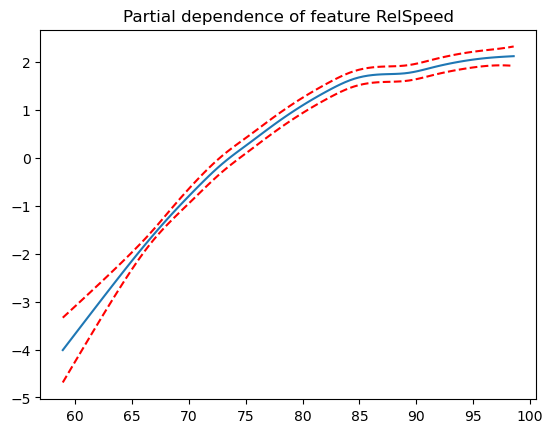

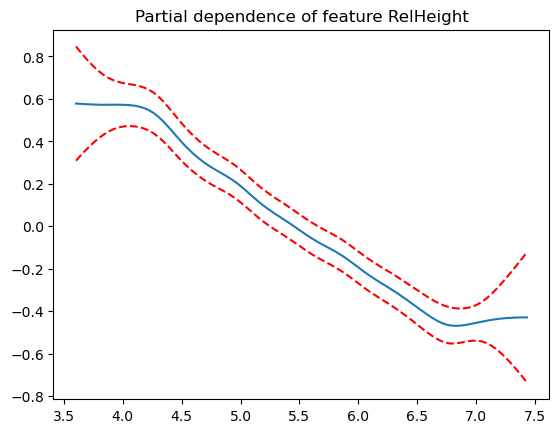

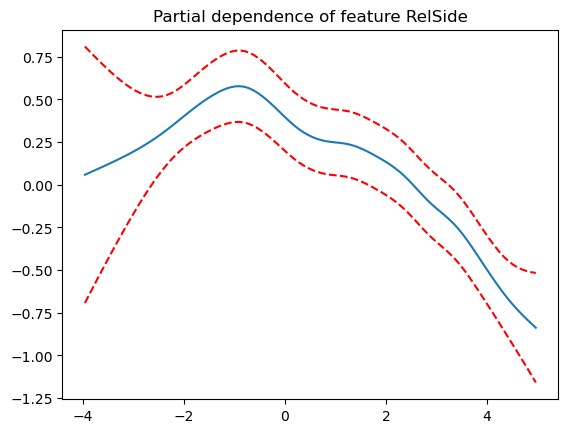

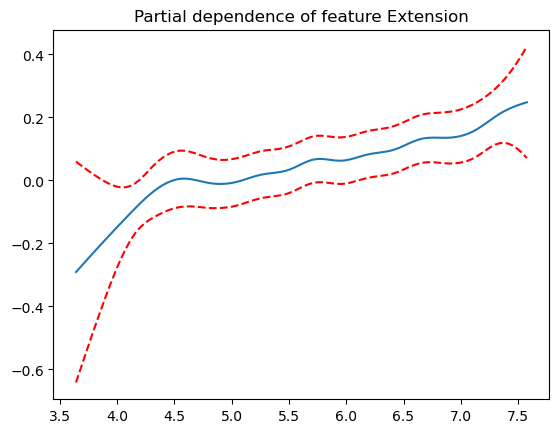

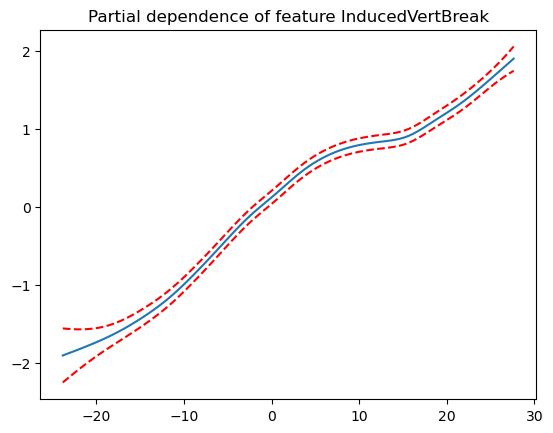

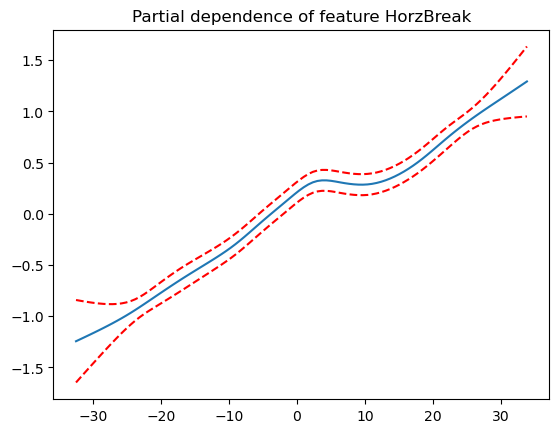

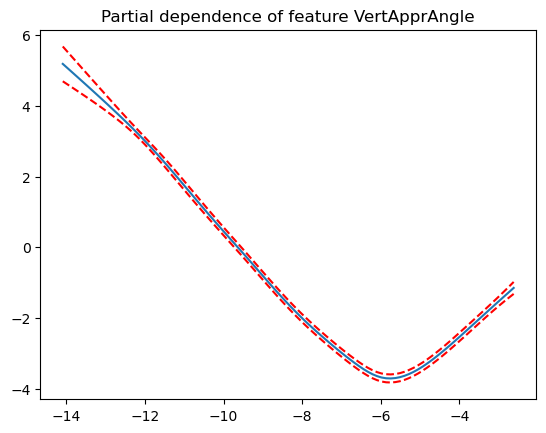

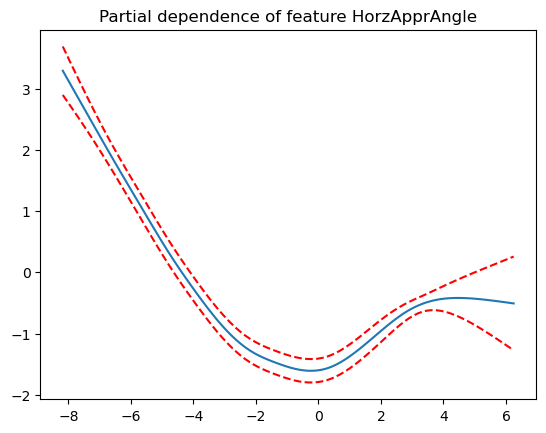

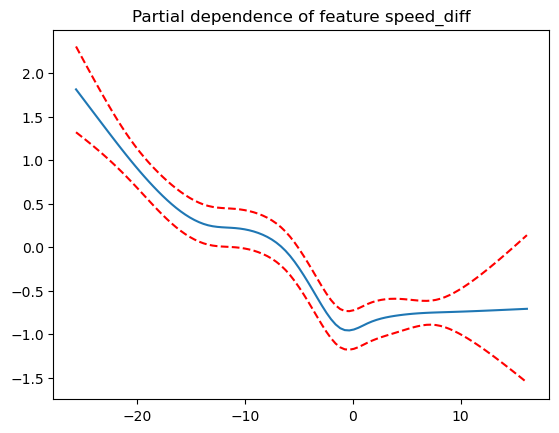

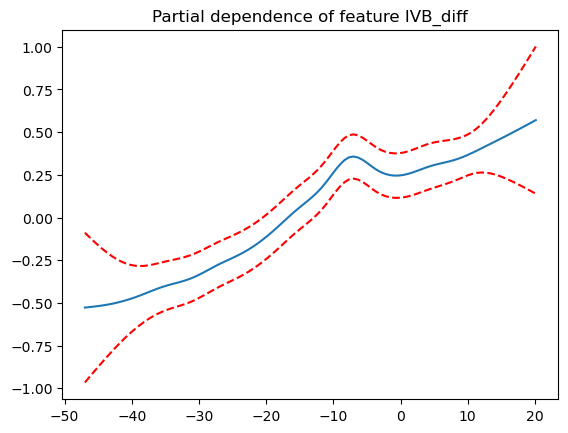

In [48]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    plt.figure()
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--')
    plt.title(f"Partial dependence of feature {feature_cols[term.feature]}")
    plt.show()

## LightGBM Classifier

In [91]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss

pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()  # balance

# initialize model
lgbm_clf = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    scale_pos_weight = pos_weight,
    colsample_bytree=0.8,
    random_state=42
)

# cross-validation log-loss
cv_logloss = cross_val_score(
    lgbm_clf, X_train, y_train, 
    cv=5, 
    scoring='neg_log_loss'
)

print("CV log-loss scores:", -cv_logloss)
print("Mean CV log-loss:", -cv_logloss.mean())

# fit and evaluate on test set
lgbm_clf.fit(X_train, y_train)
y_pred_proba = lgbm_clf.predict_proba(X_test)[:, 1]

# metrics
test_logloss = log_loss(y_test, y_pred_proba)
test_auc = roc_auc_score(y_test, y_pred_proba)
test_brier = brier_score_loss(y_test, y_pred_proba)

print("Test log-loss:", test_logloss)
print("Test AUC:", test_auc)
print("Test Brier score:", test_brier)

[LightGBM] [Info] Number of positive: 78143, number of negative: 258512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 336655, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.232116 -> initscore=-1.196402
[LightGBM] [Info] Start training from score -1.196402
[LightGBM] [Info] Number of positive: 78142, number of negative: 258513
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 336655, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.232113 -> initscore=-1.196418
[LightGBM] [Info] Start training from score -1.196418
[LightGB

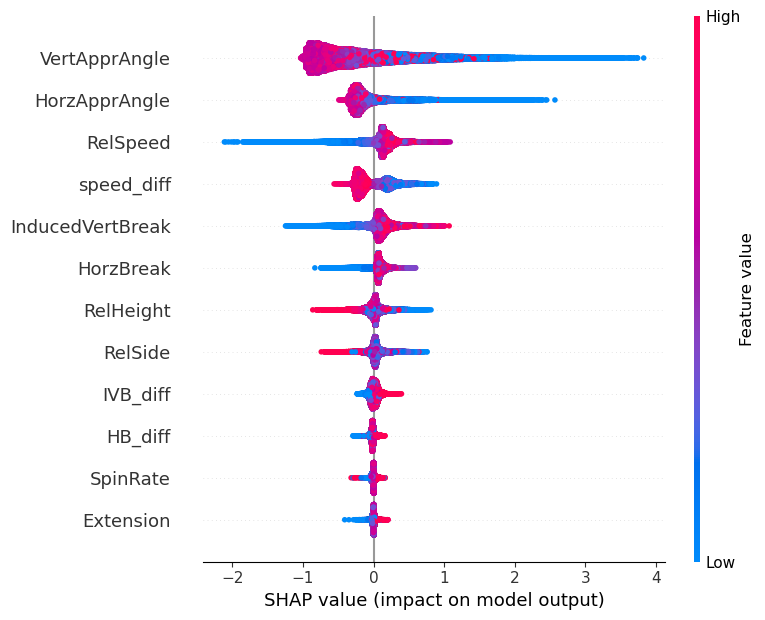

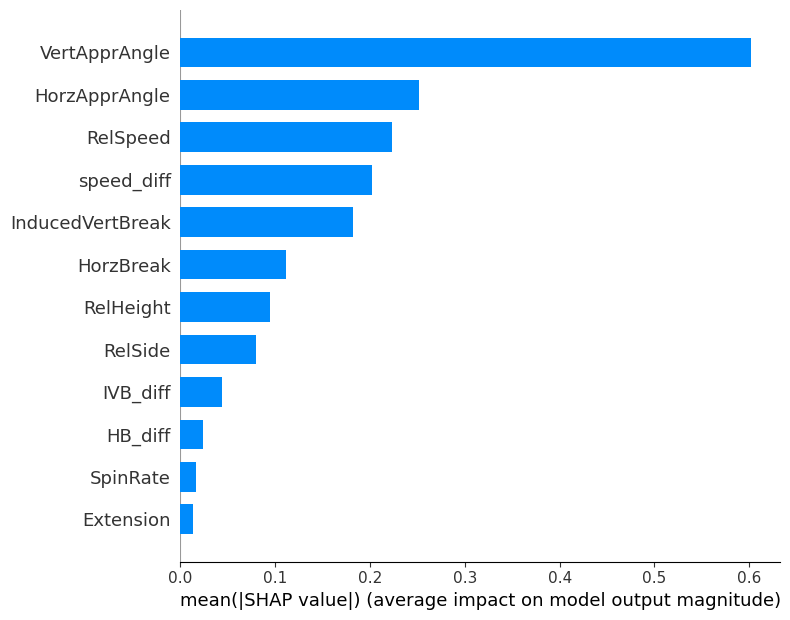

In [92]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(lgbm_clf)

# compute SHAP values for test set
shap_values = explainer.shap_values(X_test)

# ensure it's a 2d array for binary classification
if isinstance(shap_values, list):
    shap_values_pos = shap_values[1]  
else:
    shap_values_pos = shap_values 

# summary plot
shap.summary_plot(shap_values_pos, X_test, feature_names=feature_cols)

# Optional: bar plot for global importance
shap.summary_plot(shap_values_pos, X_test, feature_names=feature_cols, title = 'Feature Importance in LightGBM Classifier', plot_type="bar")



## Interpretation of these SHAP graphs: 

- More blue dots on the right = lower values pushes higher probability of a whiff
- More red dots on the right = higher values pushes higher probability of a whiff

- VertApprAngle shows that lower VAA (closer to 0) is correlated to higher probability of a whiff, which is intuitive
- Shows higher velo is somewhat correlated to more whiffs
- Higher difference in speed correlated to more whiffs
- Higher IVB, more whiffs
- More extension, more whiffs

In [93]:
cv_probs_lgbm = cross_val_predict(lgbm_clf, X, y, cv=5, method="predict_proba")[:, 1].round(3)

X_with_probs["cv_predicted_prob_lgbm"] = cv_probs_lgbm
X_with_probs.sample(10)

[LightGBM] [Info] Number of positive: 97679, number of negative: 323140
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 420819, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.232116 -> initscore=-1.196399
[LightGBM] [Info] Start training from score -1.196399
[LightGBM] [Info] Number of positive: 97678, number of negative: 323141
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 420819, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.232114 -> initscore=-1.19641

,RelSpeed,SpinRate,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,speed_diff,IVB_diff,HB_diff,cv_predicted_prob_xgb,cv_predicted_prob_lgbm
282158,83.08449,2039.930103,5.57002,2.39088,5.56448,-9.15067,-5.05445,-8.070897,-3.622370,-9.544072,-24.081162,-21.367493,0.457,0.408
207581,85.63775,2011.793250,6.69820,1.70525,5.99313,9.79607,19.74536,-8.340573,-0.667048,-9.034606,-3.387679,6.505818,0.685,0.784
388018,80.57676,2184.405893,5.61552,2.42503,6.17062,-1.76799,-5.75611,-7.263290,-2.828611,-11.714274,-19.276308,-15.825367,0.242,0.251
501420,73.04808,2047.649254,5.82744,2.79669,5.77908,2.68390,-9.14650,-9.227319,-4.428730,-8.940542,-11.943280,-22.216152,0.472,0.547
24656,92.49236,2336.245519,5.58188,1.00890,5.84238,19.90552,11.20642,-5.641665,-0.331000,-0.429910,-0.845714,0.705567,0.271,0.286
173262,88.59819,2315.044375,5.52211,1.74597,6.46554,11.14949,3.46292,-6.286241,-3.113966,-1.098912,-5.020120,-4.882916,0.629,0.523
260048,81.23659,1865.469024,5.64932,2.64042,6.35248,2.64894,-5.39063,-7.188849,-2.531416,-6.359465,-13.934481,-14.838198,0.181,0.258
427493,88.20863,2120.868385,5.43381,1.44335,5.91826,17.54493,6.51374,-5.160378,-1.091802,-0.870134,-2.964143,2.227911,0.216,0.236
84584,91.52924,2009.284830,6.72693,1.25480,5.64218,15.33454,8.14272,-5.767294,0.337422,0.540646,0.861904,-6.264558,0.409,0.305
350599,87.35632,2368.767735,6.00450,1.30135,5.28784,21.26308,8.23855,-6.308994,-0.582971,-0.036353,0.091305,-1.374938,0.273,0.261


In [101]:
print('LightGBM Predicted Whiff%:\n', X_with_probs['cv_predicted_prob_lgbm'].describe())
print('\n')
print('XGBoost Predicted Whiff%:\n', X_with_probs['cv_predicted_prob_xgb'].describe())

LightGBM Predicted Whiff%:
 count    526024.000000
mean          0.445914
std           0.191716
min           0.065000
25%           0.291000
50%           0.405000
75%           0.567000
max           0.996000
Name: cv_predicted_prob_lgbm, dtype: float64


XGBoost Predicted Whiff%:
 count    526024.000000
mean          0.439617
std           0.203728
min           0.024000
25%           0.276000
50%           0.394000
75%           0.568000
max           1.000000
Name: cv_predicted_prob_xgb, dtype: float64


## FLAML

In [ ]:
from flaml import AutoML

# --- Initialize AutoML ---
automl = AutoML()

# --- Define settings ---
settings = {
    "time_budget": 360,  # seconds to run, increase if you want more search
    "metric": "accuracy",  # could also use: 'roc_auc', 'f1', etc.
    "task": "classification",  # regression if your target is continuous
    "log_file_name": "automl.log",
    "verbose": 1,
}

# --- Run AutoML ---
automl.fit(X_train=X, y_train=y, **settings)

# --- Best model found ---
print("Best model:", automl.best_estimator)
print("Best config:", automl.best_config)
print("Best score:", automl.best_loss)  # lower is better depending on metric
print("Training duration:", automl.best_config_train_time)

# --- Predictions ---
y_pred = automl.predict(X)
y_prob = automl.predict_proba(X)[:, 1]  # if you want probabilities
